# Predict Churning customers

The goal of this project is to predict the customers who want to cancel a credit card program, such that actions can be taken to prevent the event from happening.

The top priority is to identify customers who are getting churned. Even if we predict non-churning customers as churned, it won’t harm our business. But predicting churning customers as non-churning will do. So recall (True positives/(True positives + False negatives) must be high.

The dataset is strongly un-balanced: only 16% of customers churned.

The notebook is organized as follow:

+ In Section 1, the dataset is explored, checking if null values are present.

+ In Section 2, feature engineering is performed as follow:
    + The categorical target feature (the Attrition_Flag) is converted to numerical.
    + Other categorical features are one-hot encoded.
    + The dataset is divided into train and test, using stratified sampling.
    + The outliers in the training dataset are identified.
    + A data preprocessing pipeline is built, removing the outliers identified in the previous step and standardizing each feature.
    + Highly correlated features are removed, identifing highly correleted feature pairs
    + Highly multicollinear features are removed, estimating the variance inflation factor

+ In Section 3, XGBoost is used as a model for predicting churned/not churned customers. Model hyperparameters are searched as follow:
    + An objective function is defined. The objective function computes the average value of the cross-validation score on the training dataset, using the negative log loss as a scoring metric
    + The maximum value of the objective function is searched using the Bayesian framework Optuna [https://optuna.org/]
    + On the test dataset, the recall value is 0.927

# Common imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

%matplotlib inline

## 1. Explore dataset

In [2]:
bankchurners = pd.read_csv("BankChurners.csv")
bankchurners.head(10)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998
5,713061558,Existing Customer,44,M,2,Graduate,Married,$40K - $60K,Blue,36,...,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311,0.000055,0.99994
6,810347208,Existing Customer,51,M,4,Unknown,Married,$120K +,Gold,46,...,34516.0,2264,32252.0,1.975,1330,31,0.722,0.066,0.000123,0.99988
7,818906208,Existing Customer,32,M,0,High School,Unknown,$60K - $80K,Silver,27,...,29081.0,1396,27685.0,2.204,1538,36,0.714,0.048,0.000086,0.99991
8,710930508,Existing Customer,37,M,3,Uneducated,Single,$60K - $80K,Blue,36,...,22352.0,2517,19835.0,3.355,1350,24,1.182,0.113,0.000045,0.99996
9,719661558,Existing Customer,48,M,2,Graduate,Single,$80K - $120K,Blue,36,...,11656.0,1677,9979.0,1.524,1441,32,0.882,0.144,0.000303,0.99970


In [3]:
bankchurners.columns

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')

## Ignore the last 2 columns (as suggested by the data description section)

In [4]:
bankchurners.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis=1, inplace=True)

## How many NaNs values are present?

In [5]:
bankchurners.isnull().sum()

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [6]:
bankchurners.describe()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


# 2. Feature Engineering

## CLIENTNUM will not have predictive power, it is an id

In [7]:
bankchurners.drop(['CLIENTNUM'],axis=1,inplace=True)

## Which columns are numerical and which categorical?

In [8]:
numerical_features = bankchurners._get_numeric_data().columns
numerical_features

Index(['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

In [9]:
# Categorical Columns
categorical_features = bankchurners.select_dtypes(include='object').columns
categorical_features

Index(['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category'],
      dtype='object')

## Convert the income into ordinal features, it makes sense for this categorical variable

<AxesSubplot:xlabel='Income_Category', ylabel='count'>

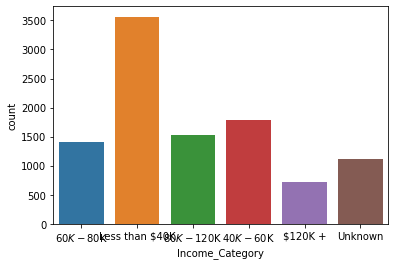

In [10]:
sns.countplot('Income_Category', data=bankchurners)

In [11]:
bankchurners['Income_Category'] = bankchurners['Income_Category'].replace({
    'Unknown':0,
    'Less than $40K':1,
    '$40K - $60K':2,
    '$60K - $80K':3,
    '$80K - $120K':4,
    '$120K +':5
})

## Convert attrition_flag to numerical

<AxesSubplot:xlabel='Attrition_Flag', ylabel='count'>

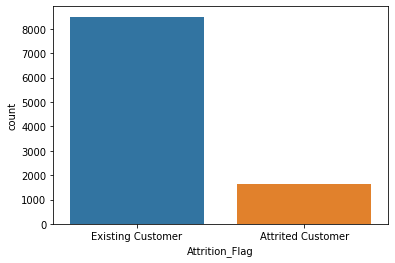

In [12]:
sns.countplot('Attrition_Flag', data=bankchurners)

In [13]:
bankchurners['Attrition_Flag'] = bankchurners['Attrition_Flag'].replace({
    'Existing Customer':0,
    'Attrited Customer':1,
})

## For the other categorical variables, use dummies (OneHot encoding)

In [14]:
categorical = bankchurners.select_dtypes(include='object').columns
categorical

Index(['Gender', 'Education_Level', 'Marital_Status', 'Card_Category'], dtype='object')

In [15]:
bankchurners = pd.get_dummies(bankchurners, columns = categorical, drop_first=True)

In [16]:
bankchurners.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Attrition_Flag                 10127 non-null  int64  
 1   Customer_Age                   10127 non-null  int64  
 2   Dependent_count                10127 non-null  int64  
 3   Income_Category                10127 non-null  int64  
 4   Months_on_book                 10127 non-null  int64  
 5   Total_Relationship_Count       10127 non-null  int64  
 6   Months_Inactive_12_mon         10127 non-null  int64  
 7   Contacts_Count_12_mon          10127 non-null  int64  
 8   Credit_Limit                   10127 non-null  float64
 9   Total_Revolving_Bal            10127 non-null  int64  
 10  Avg_Open_To_Buy                10127 non-null  float64
 11  Total_Amt_Chng_Q4_Q1           10127 non-null  float64
 12  Total_Trans_Amt                10127 non-null 

## Raname columns to remove white spaces and other charaters incompatible with patsy (used in the next section)

In [17]:
bankchurners.rename(columns={
    "Education_Level_High School": "Education_Level_High_School",
    "Education_Level_Post-Graduate": "Education_Level_Post_Graduate",
},inplace=True)
bankchurners.columns.values

array(['Attrition_Flag', 'Customer_Age', 'Dependent_count',
       'Income_Category', 'Months_on_book', 'Total_Relationship_Count',
       'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit',
       'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1',
       'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1',
       'Avg_Utilization_Ratio', 'Gender_M', 'Education_Level_Doctorate',
       'Education_Level_Graduate', 'Education_Level_High_School',
       'Education_Level_Post_Graduate', 'Education_Level_Uneducated',
       'Education_Level_Unknown', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Unknown',
       'Card_Category_Gold', 'Card_Category_Platinum',
       'Card_Category_Silver'], dtype=object)

## Split the dataset in train and dev, before any other analysis

In [18]:
from sklearn.model_selection import train_test_split
y = bankchurners['Attrition_Flag']
X = bankchurners.drop(['Attrition_Flag'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify =y)

In [19]:
train = pd.concat([X_train, y_train],axis=1)
test = pd.concat([X_test, y_test],axis=1)

## Check outliers on numerical features

In [20]:
sns.set(font_scale=1.5)
def box_plot(key):
    fig = plt.figure(figsize=(30, 20));
    sns.boxplot(x='Attrition_Flag', y=key, data=train[['Attrition_Flag', key]])

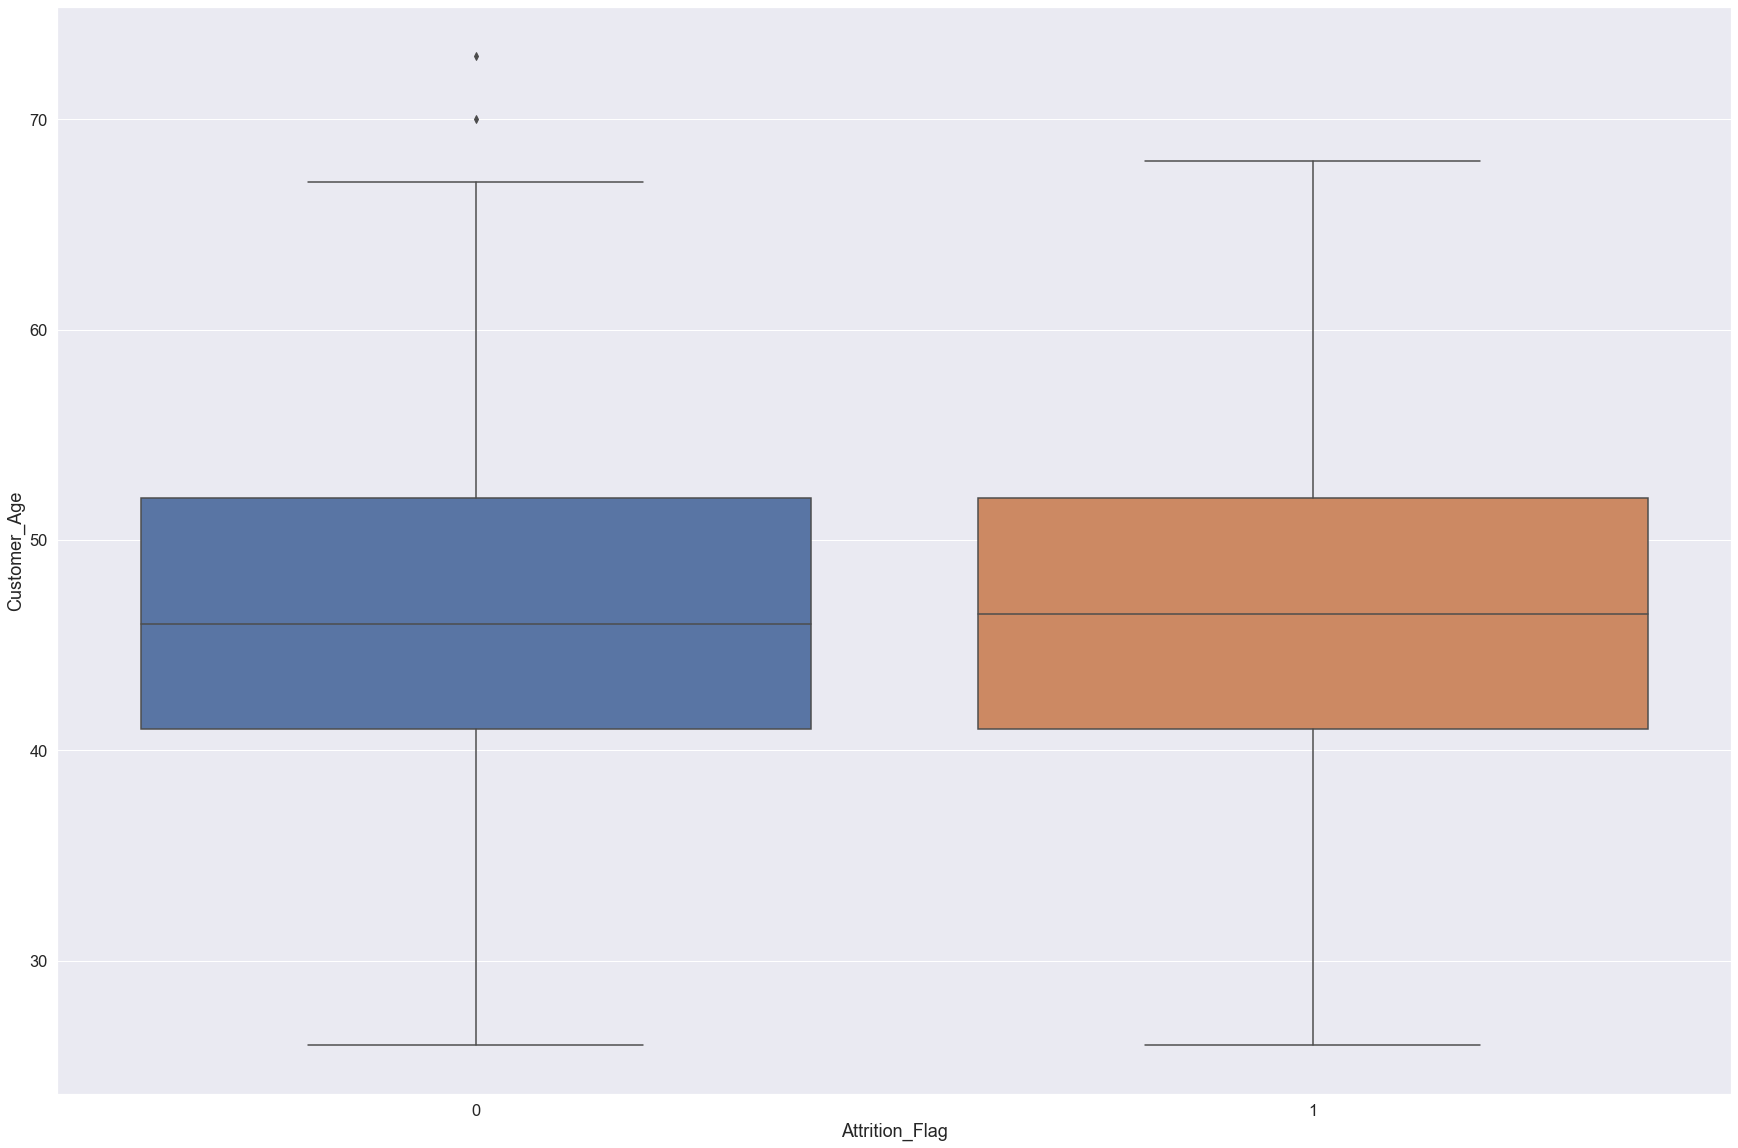

In [21]:
box_plot('Customer_Age')

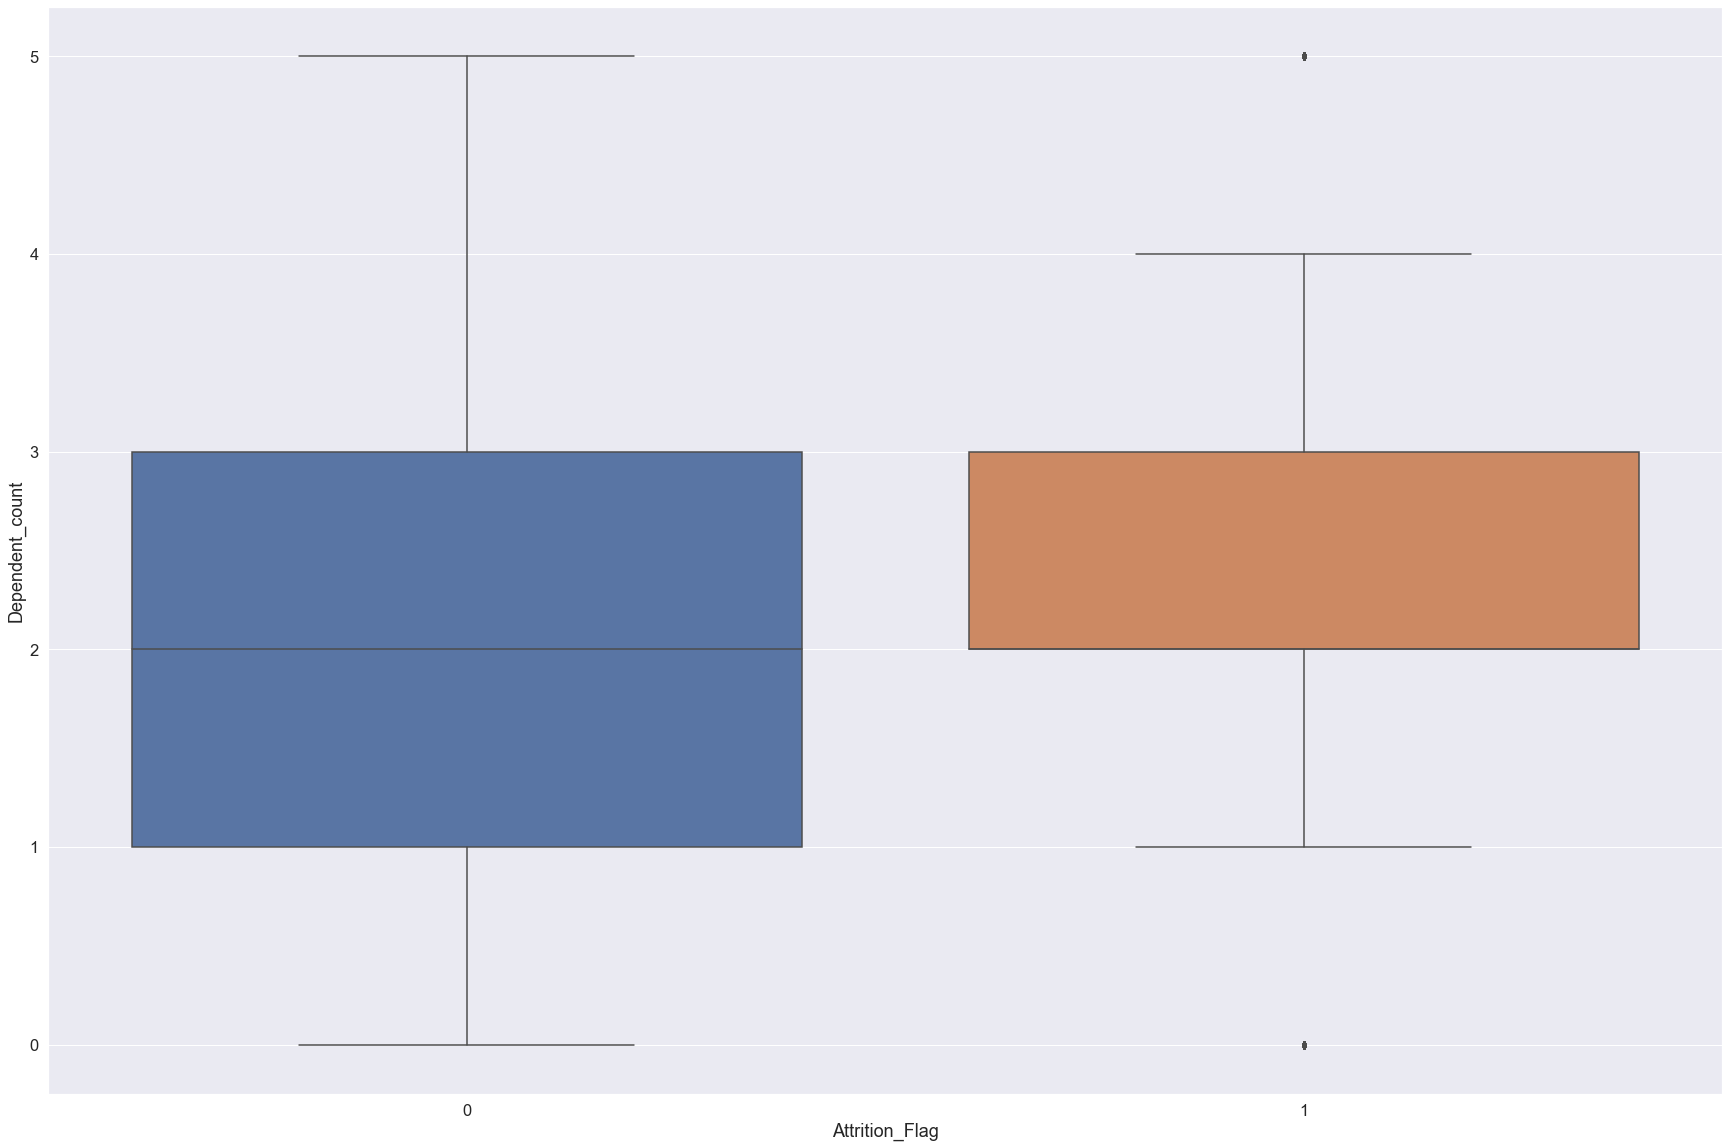

In [22]:
box_plot('Dependent_count')

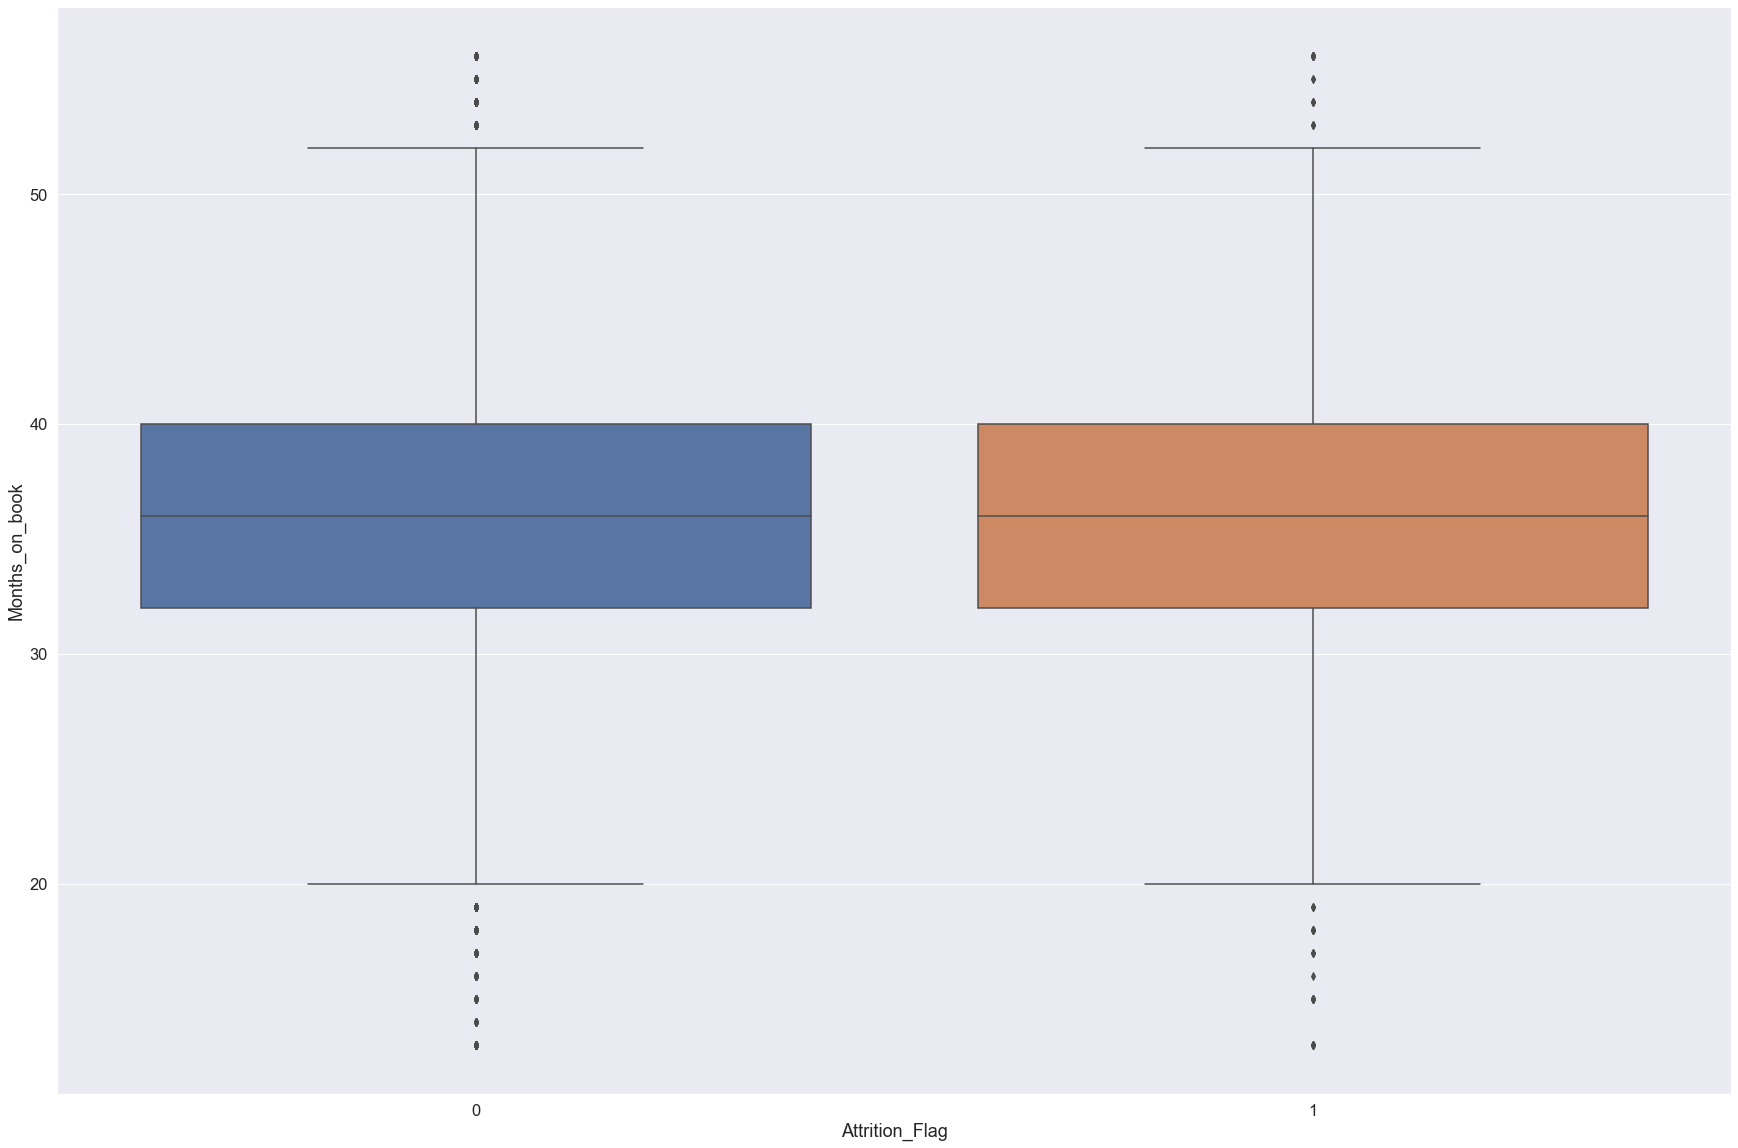

In [23]:
box_plot('Months_on_book')

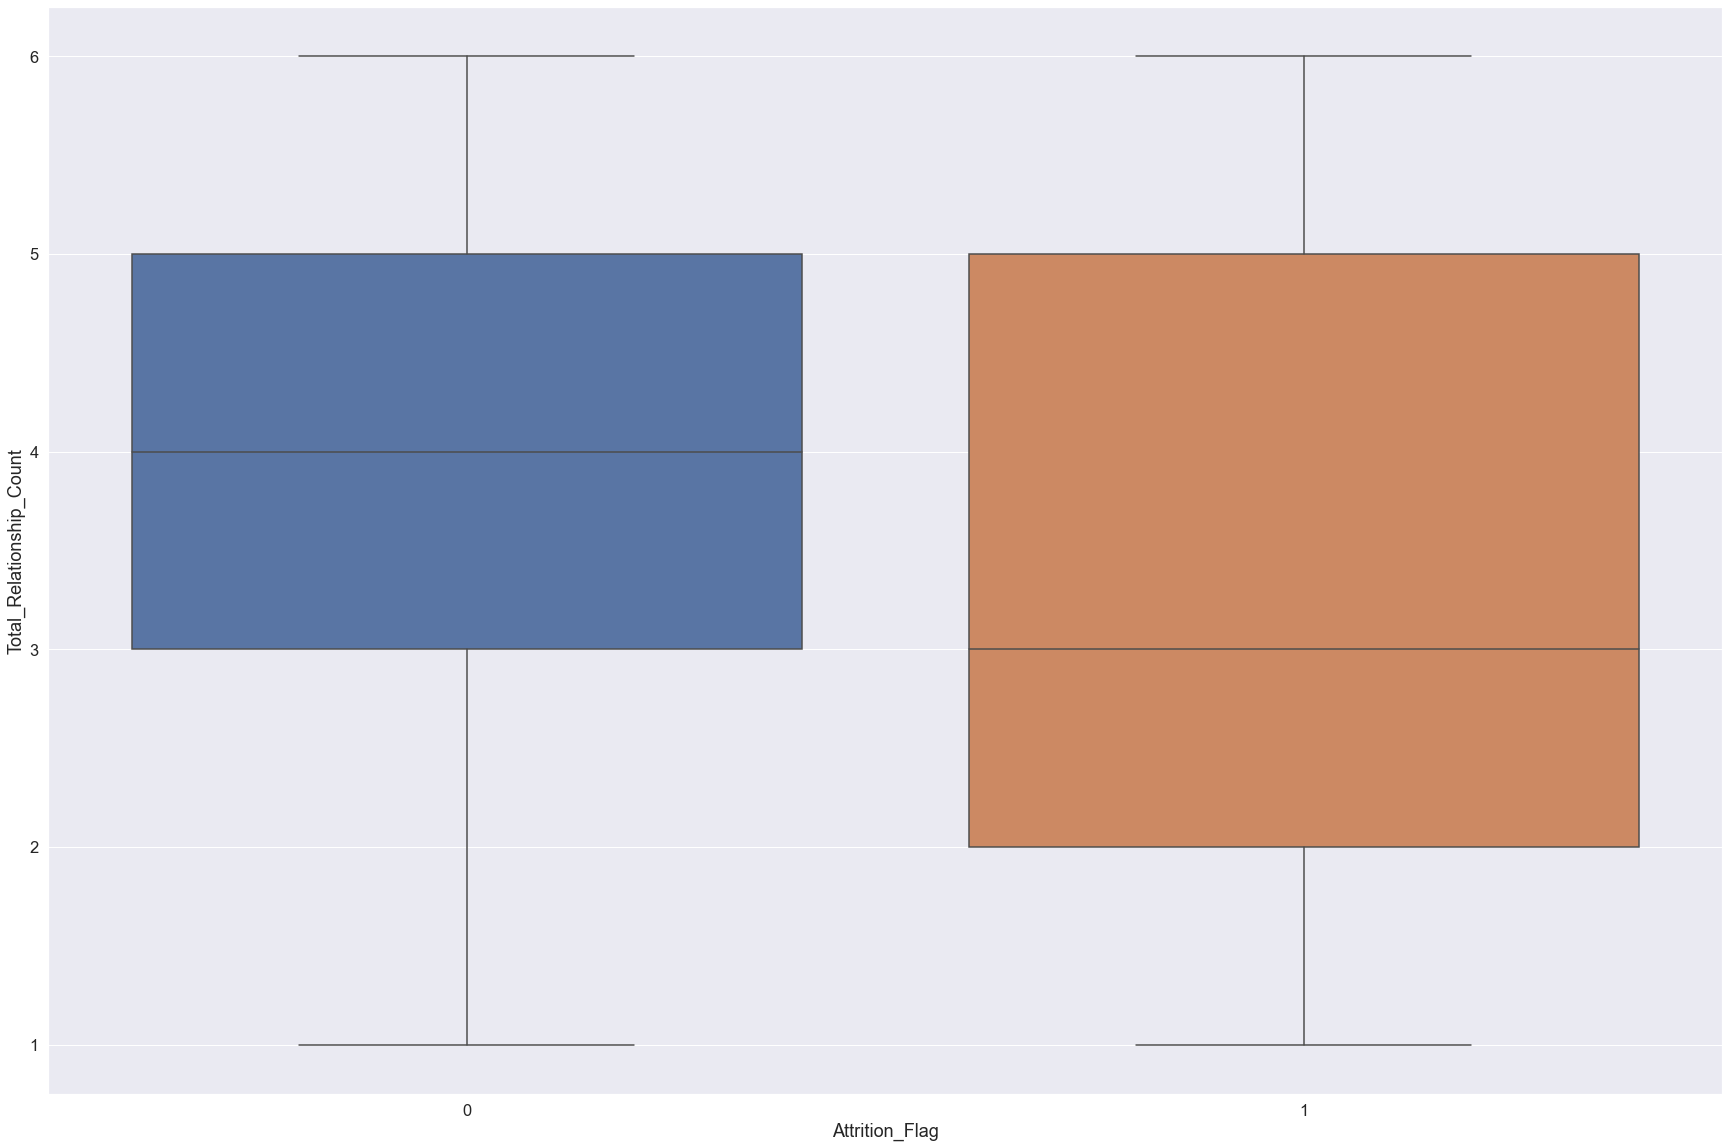

In [24]:
box_plot('Total_Relationship_Count')

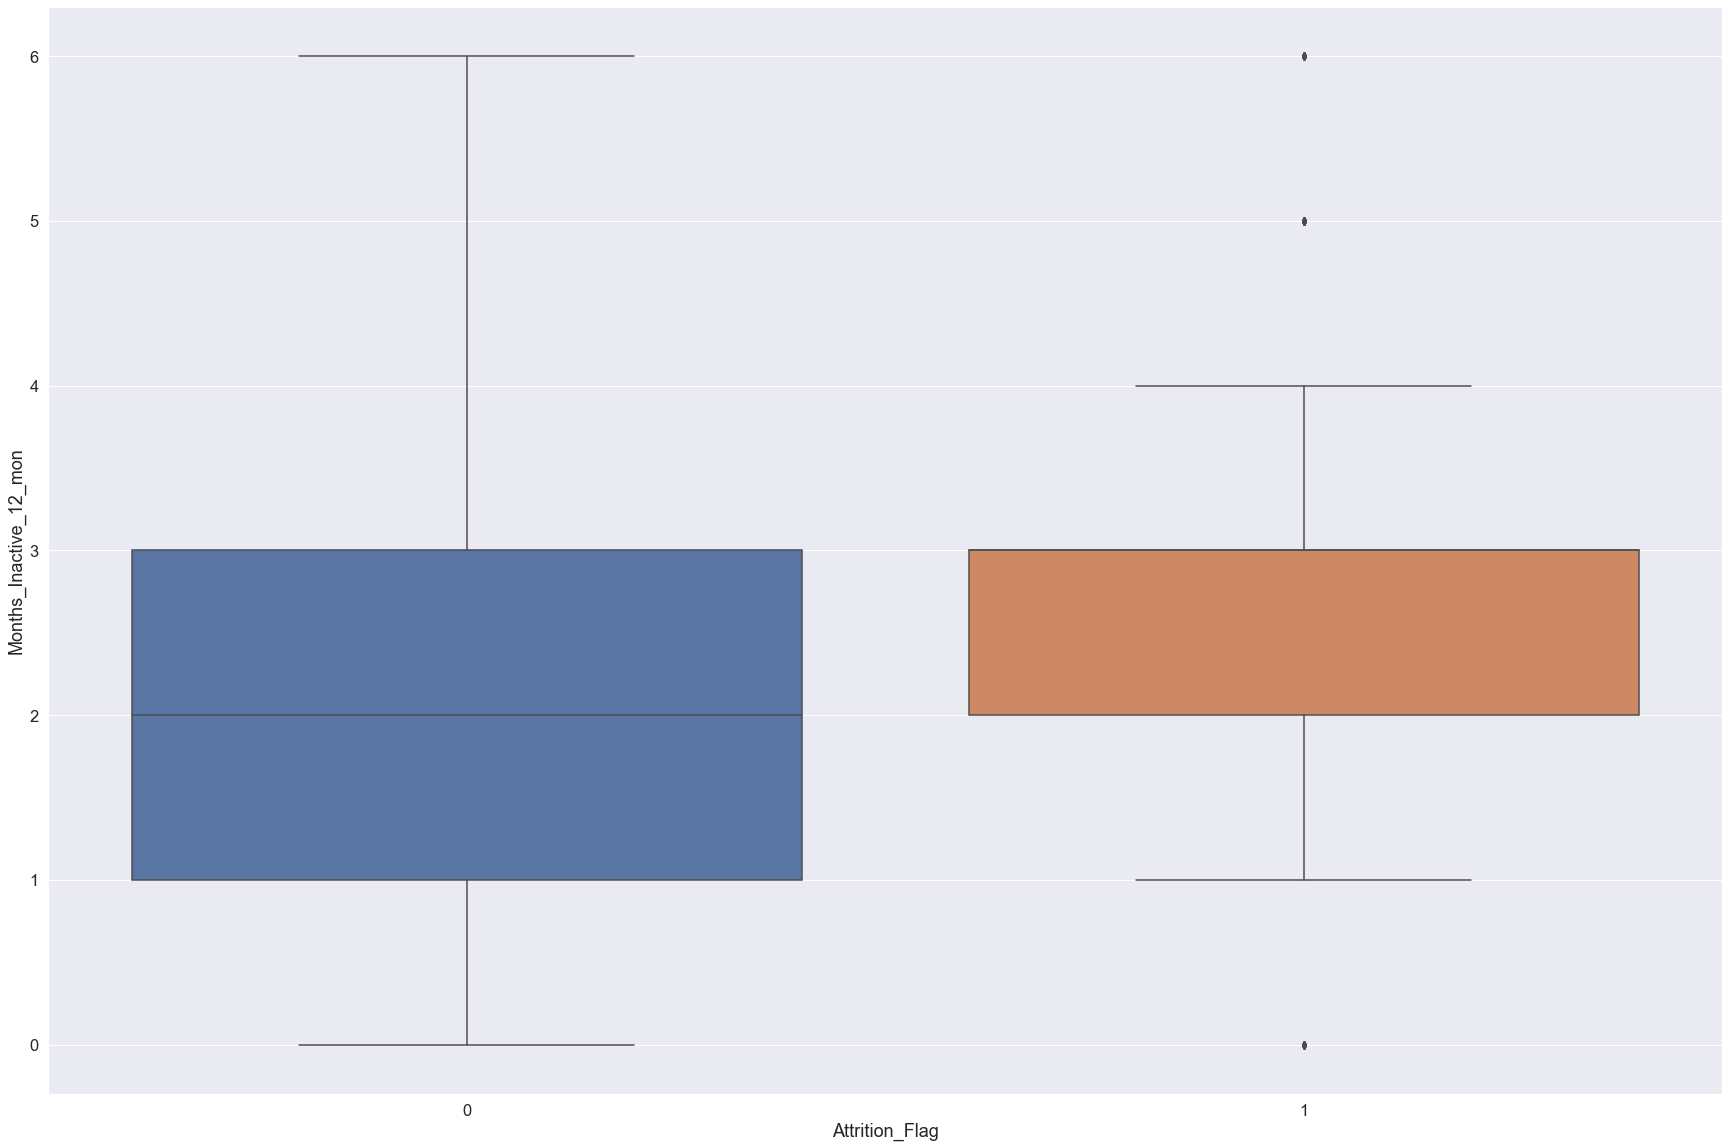

In [25]:
box_plot('Months_Inactive_12_mon')

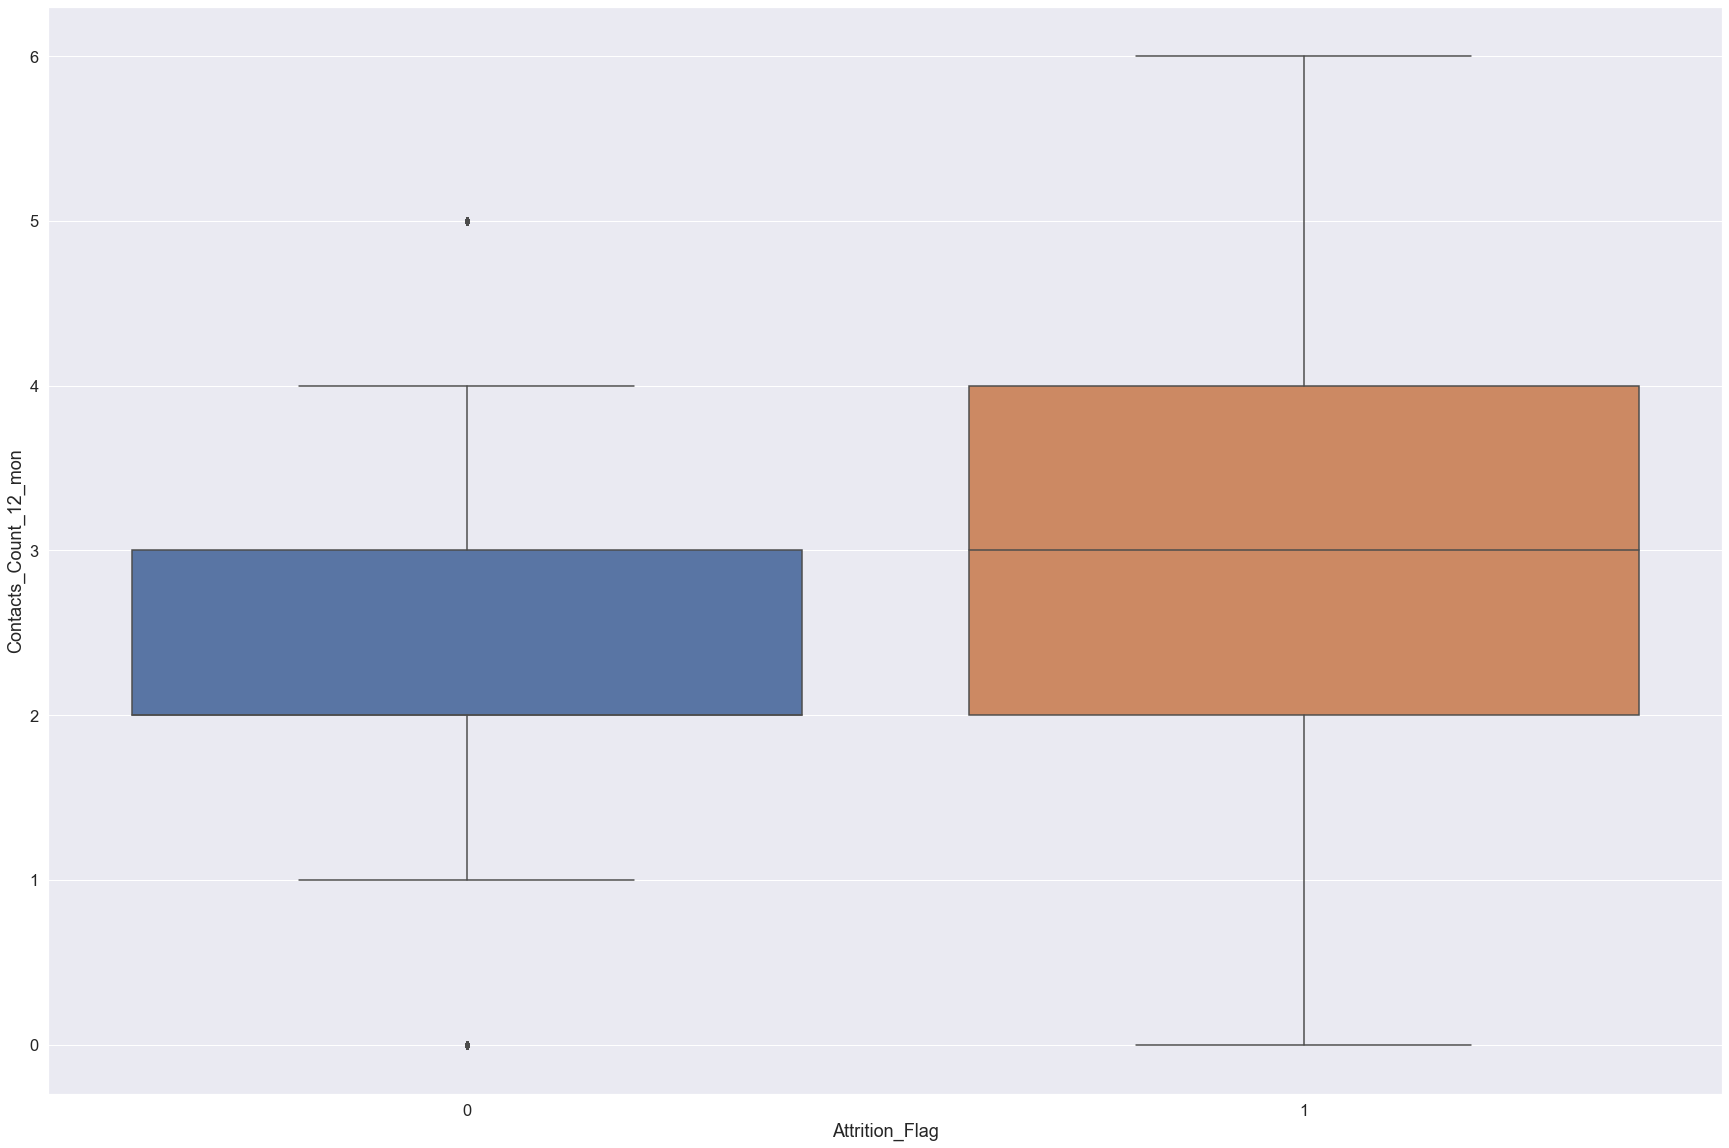

In [26]:
box_plot('Contacts_Count_12_mon')

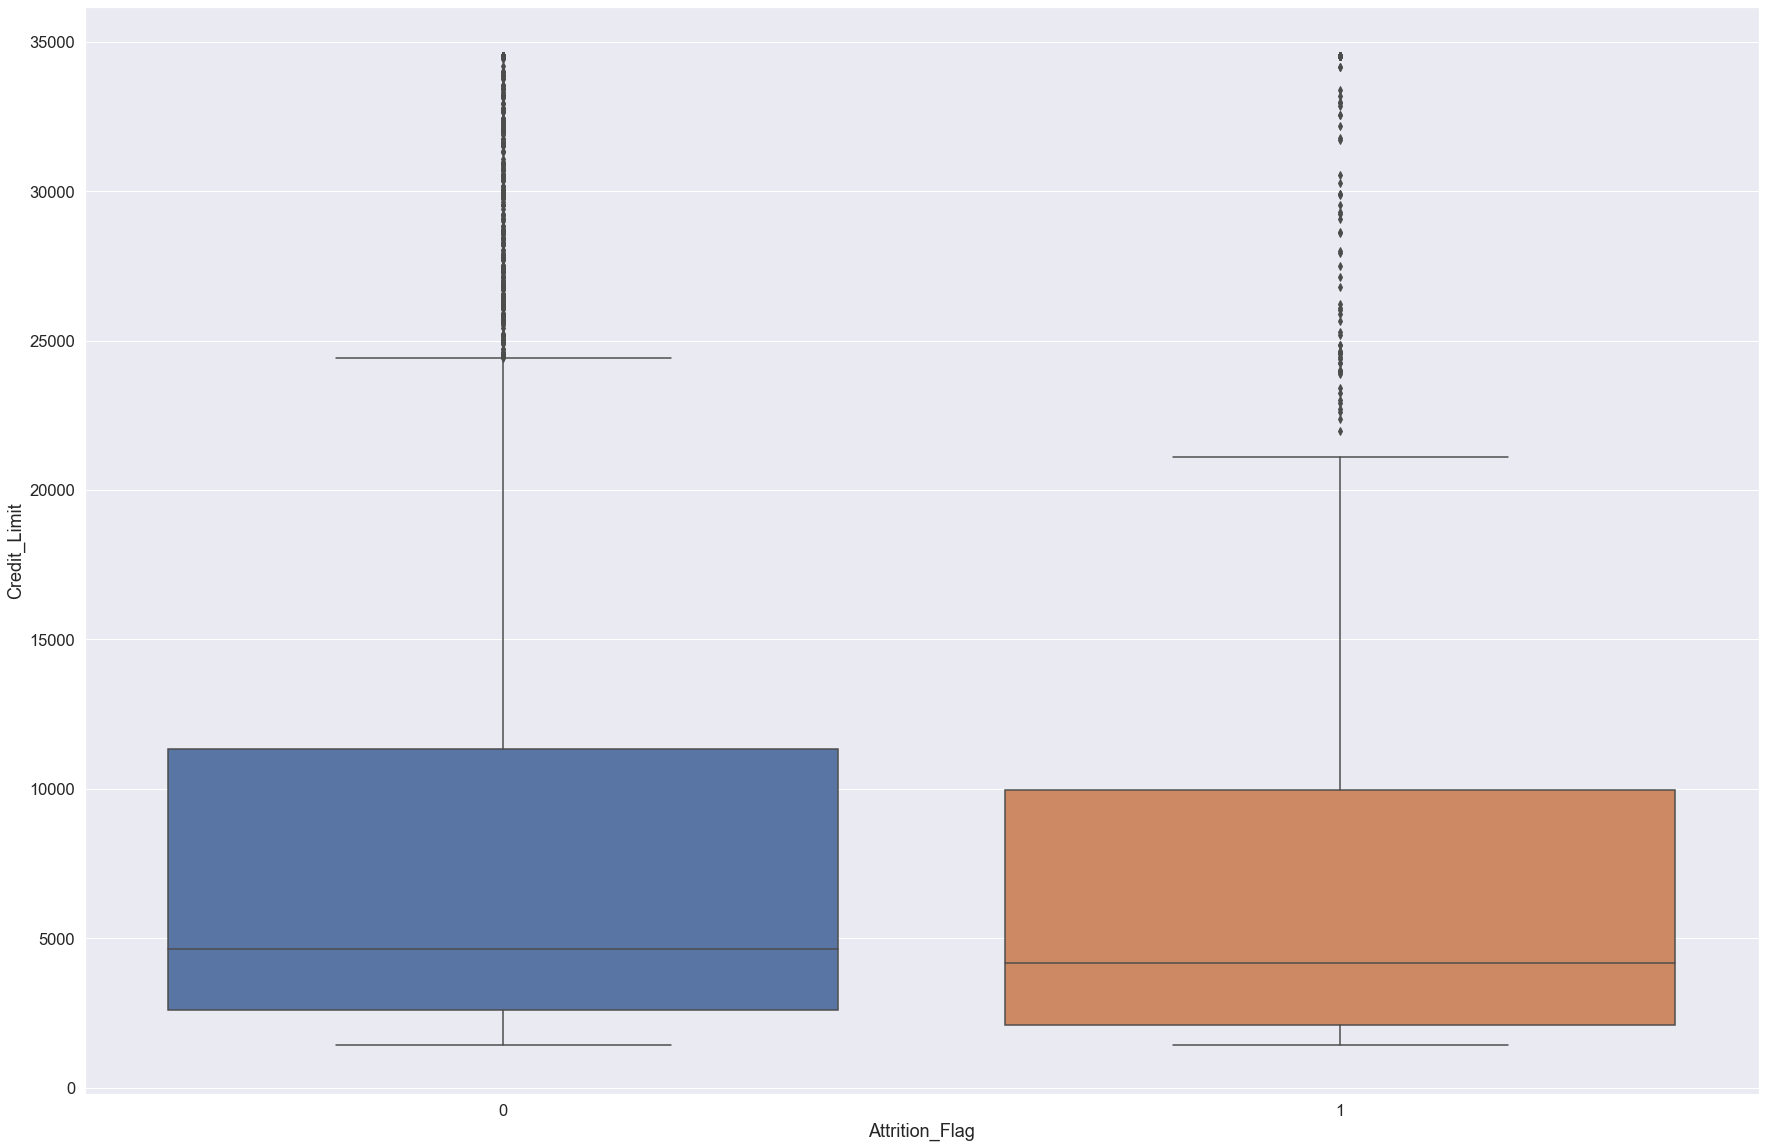

In [27]:
box_plot('Credit_Limit')

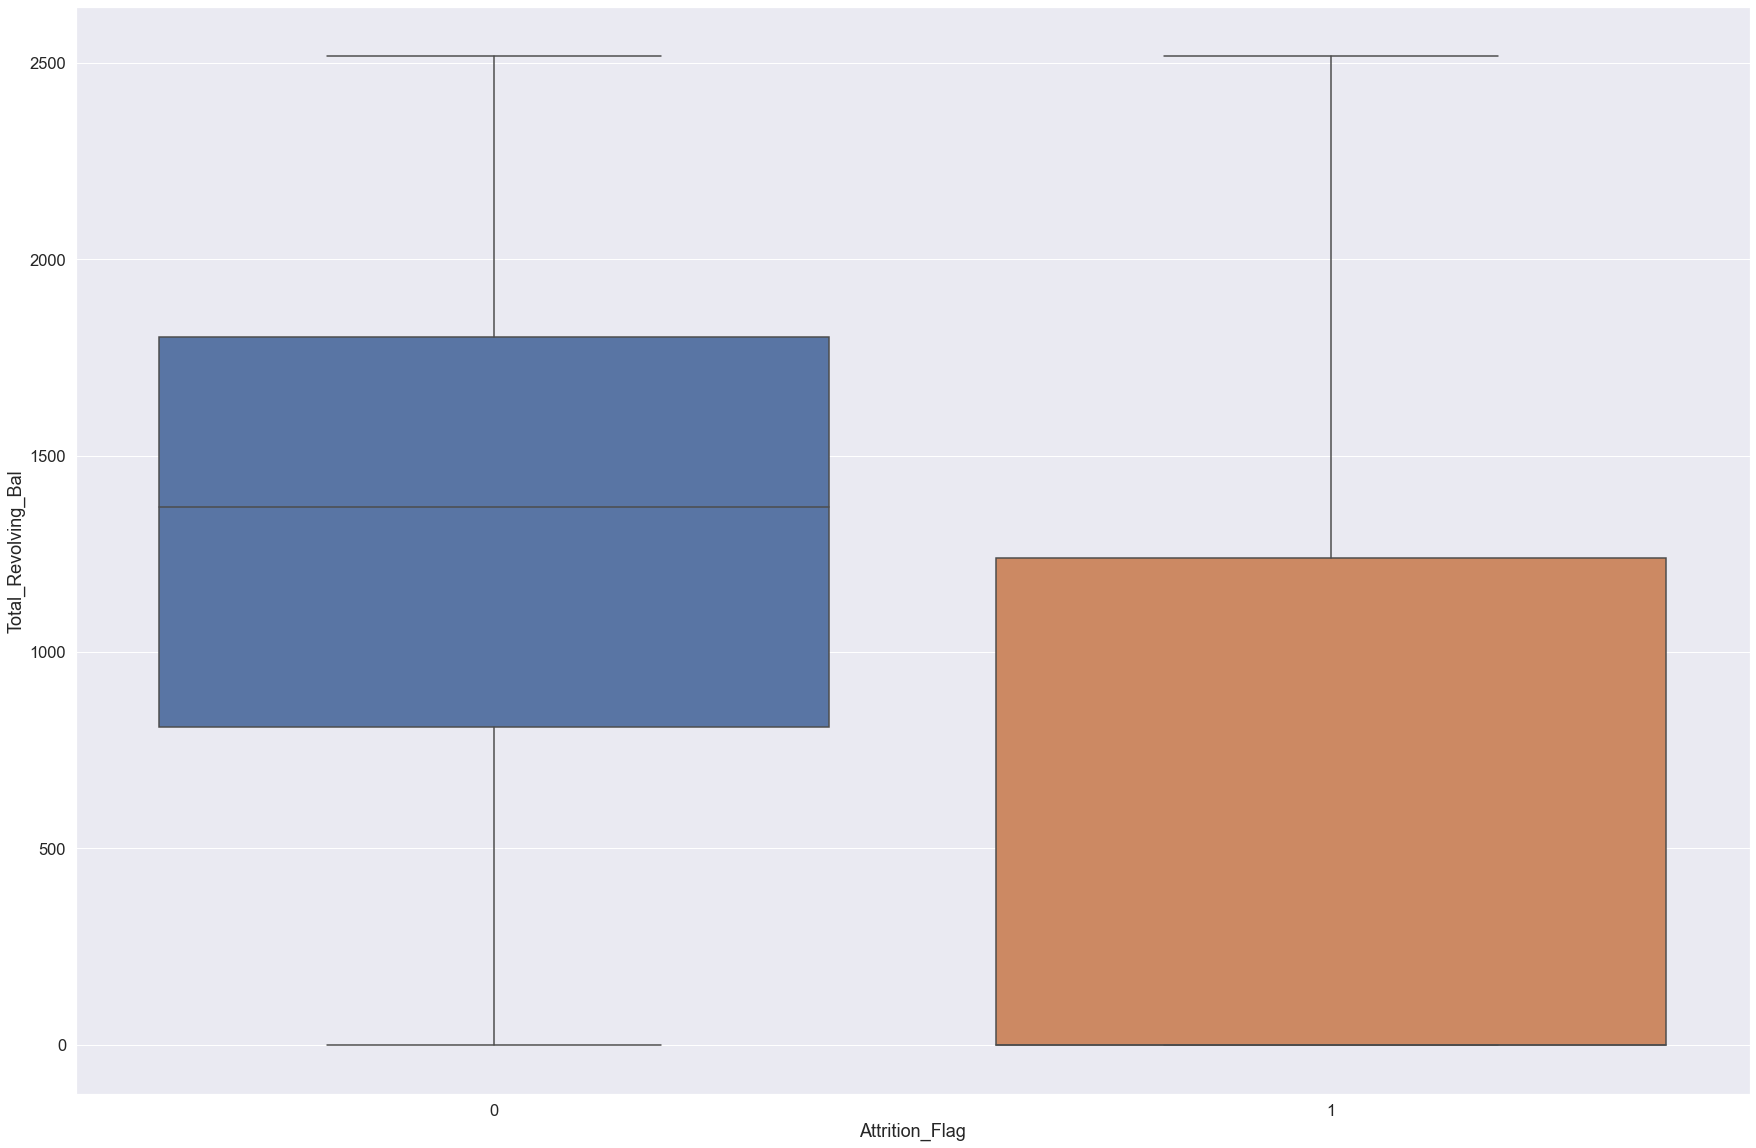

In [28]:
box_plot('Total_Revolving_Bal')

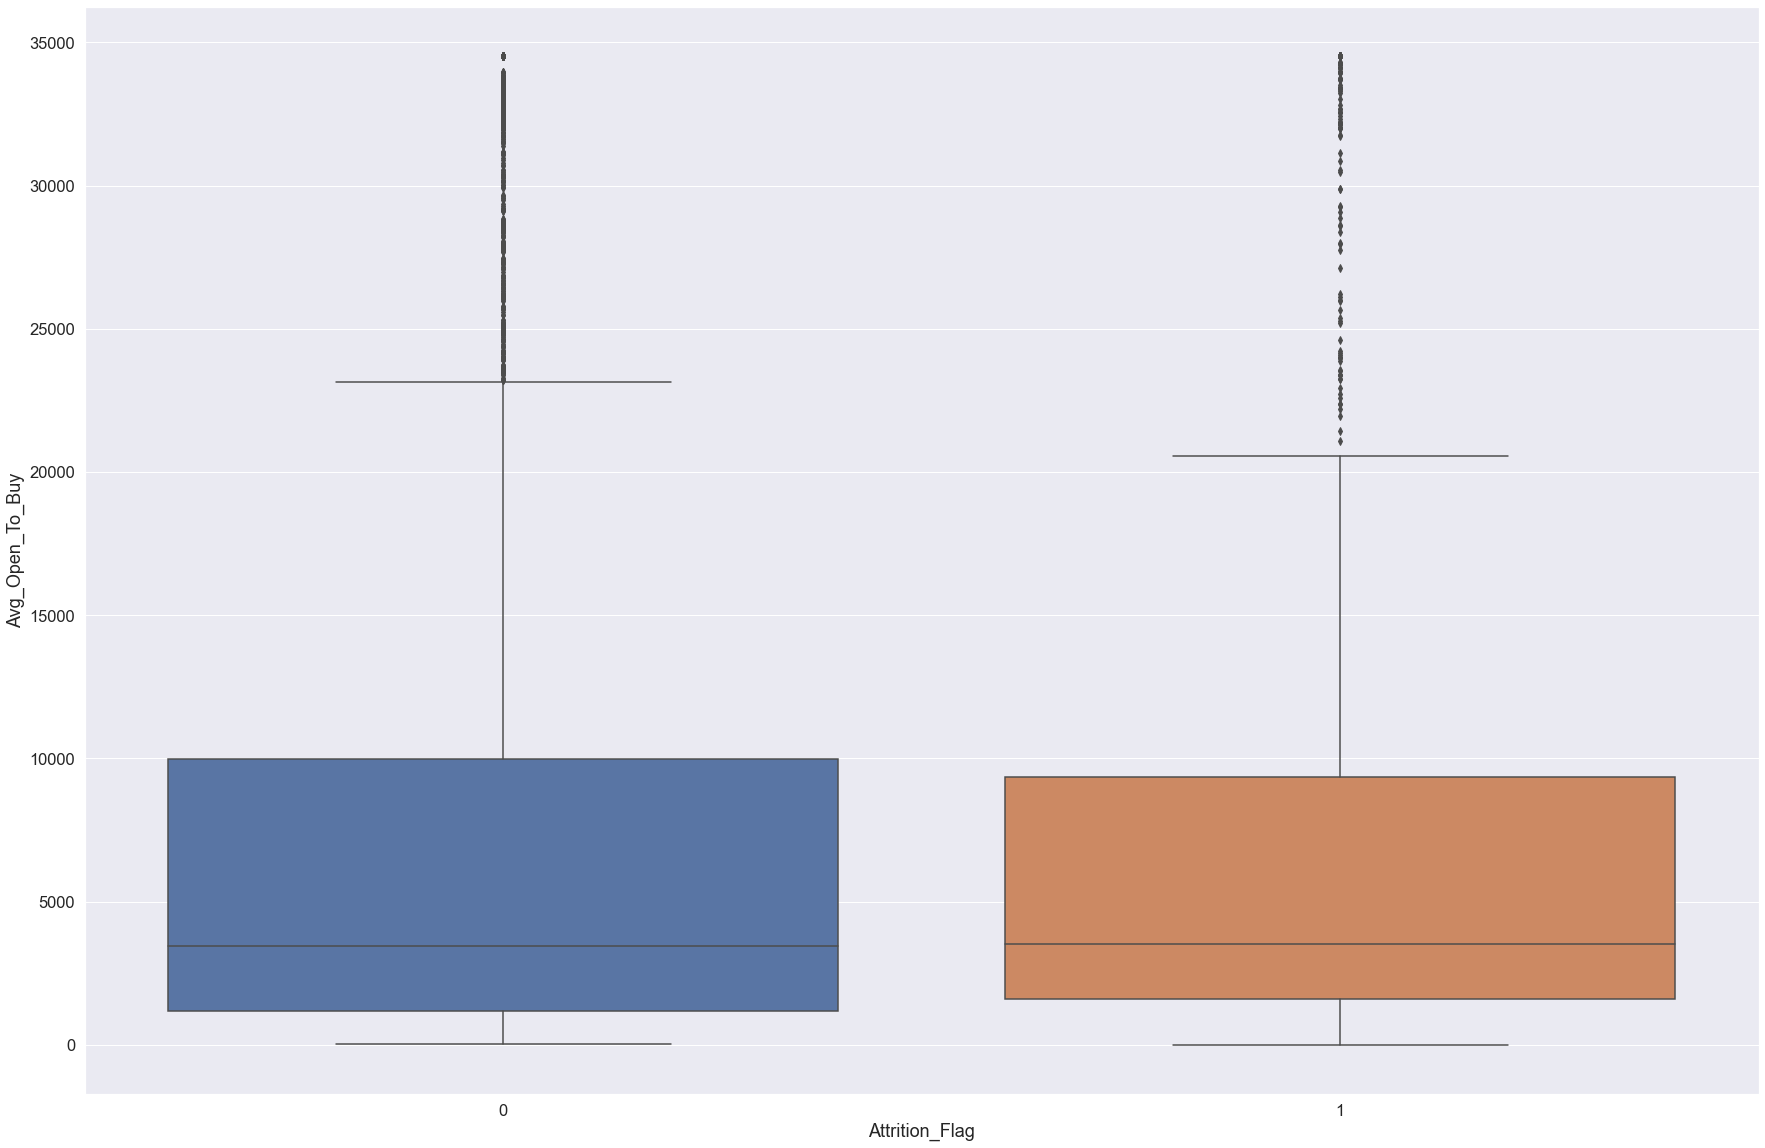

In [29]:
box_plot('Avg_Open_To_Buy')

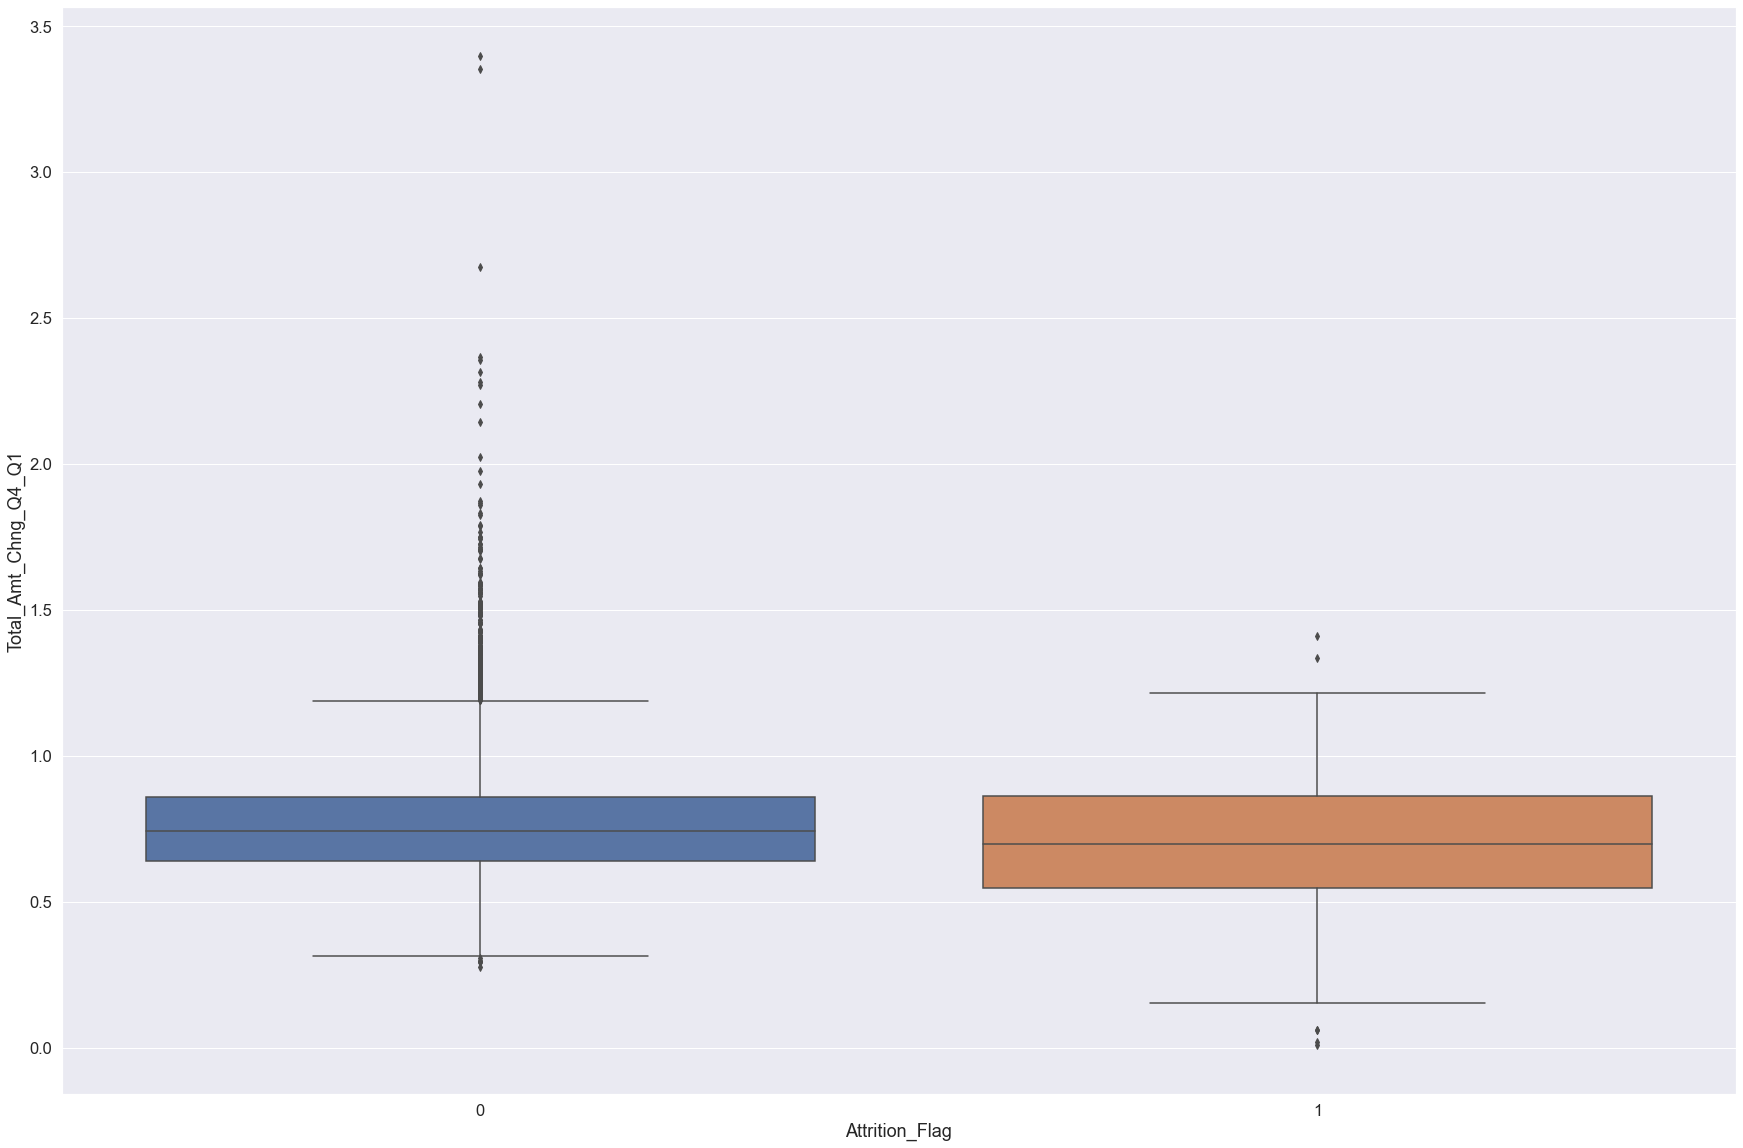

In [30]:
box_plot('Total_Amt_Chng_Q4_Q1')

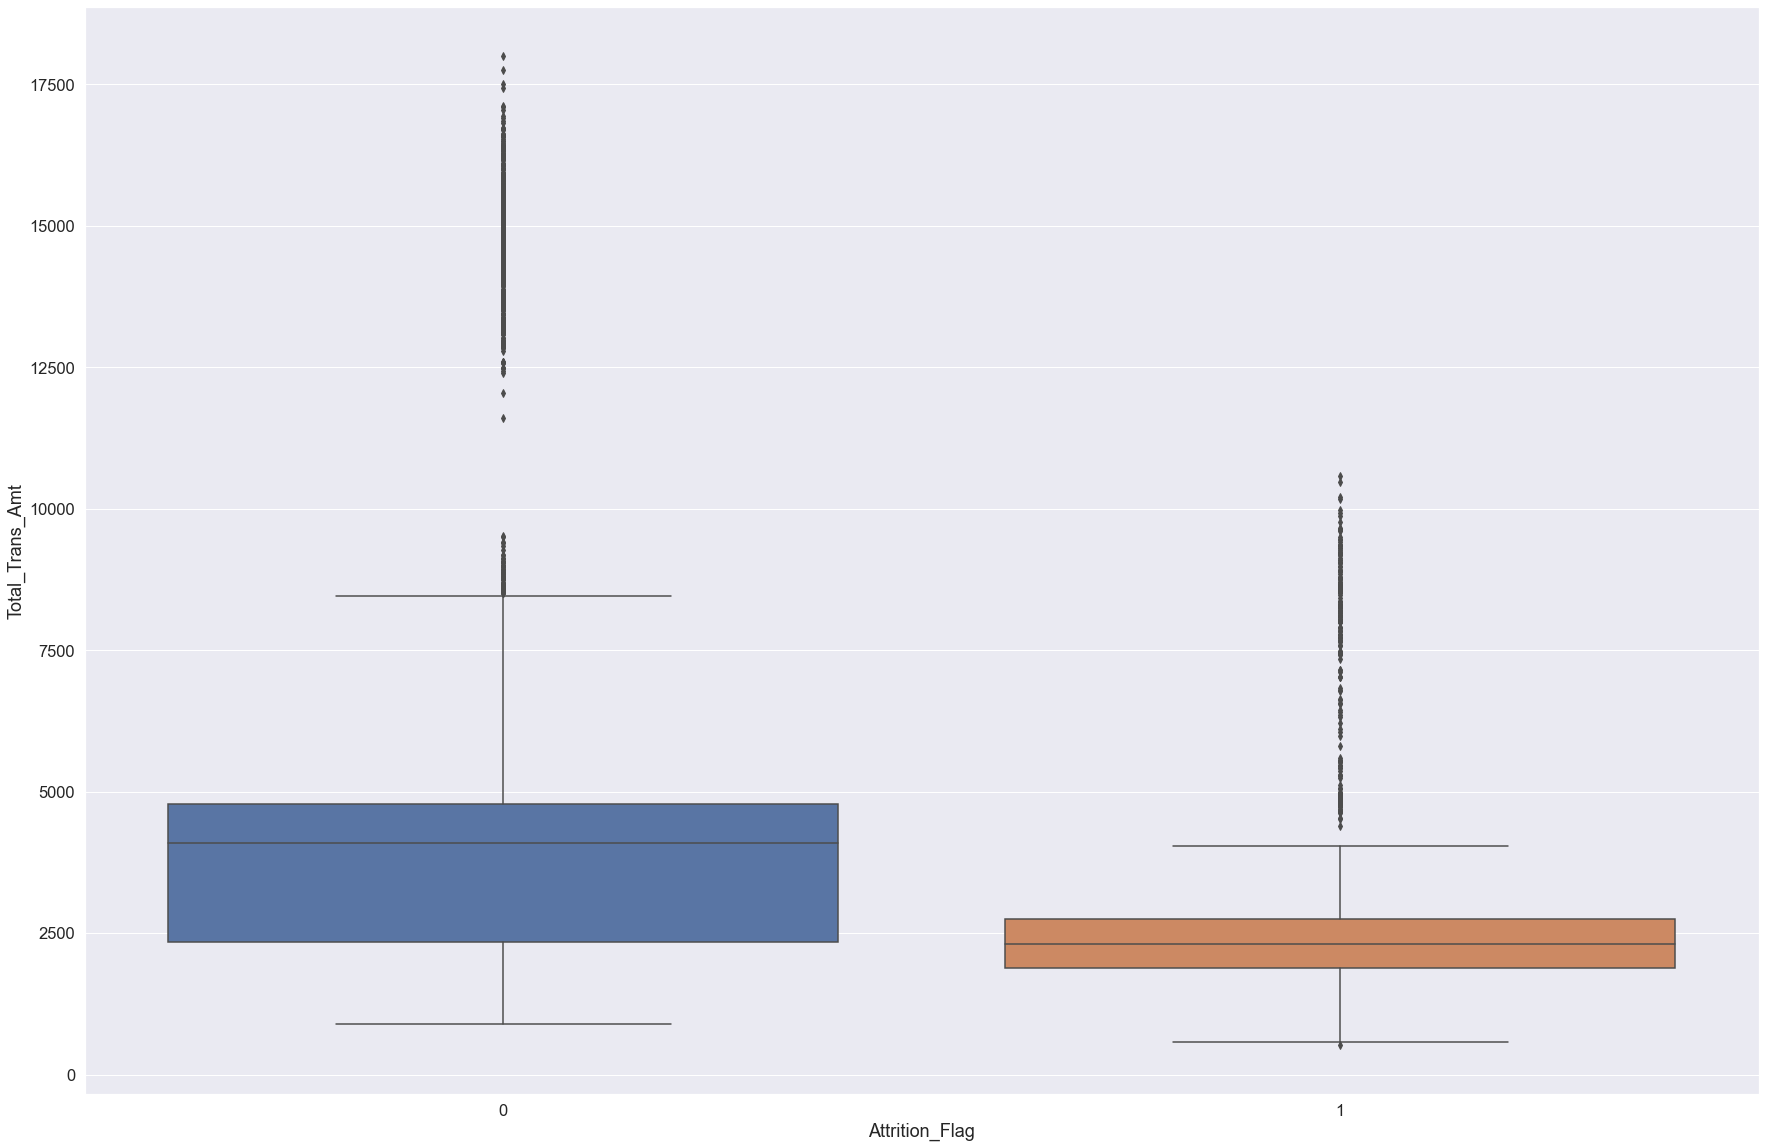

In [31]:
box_plot('Total_Trans_Amt')

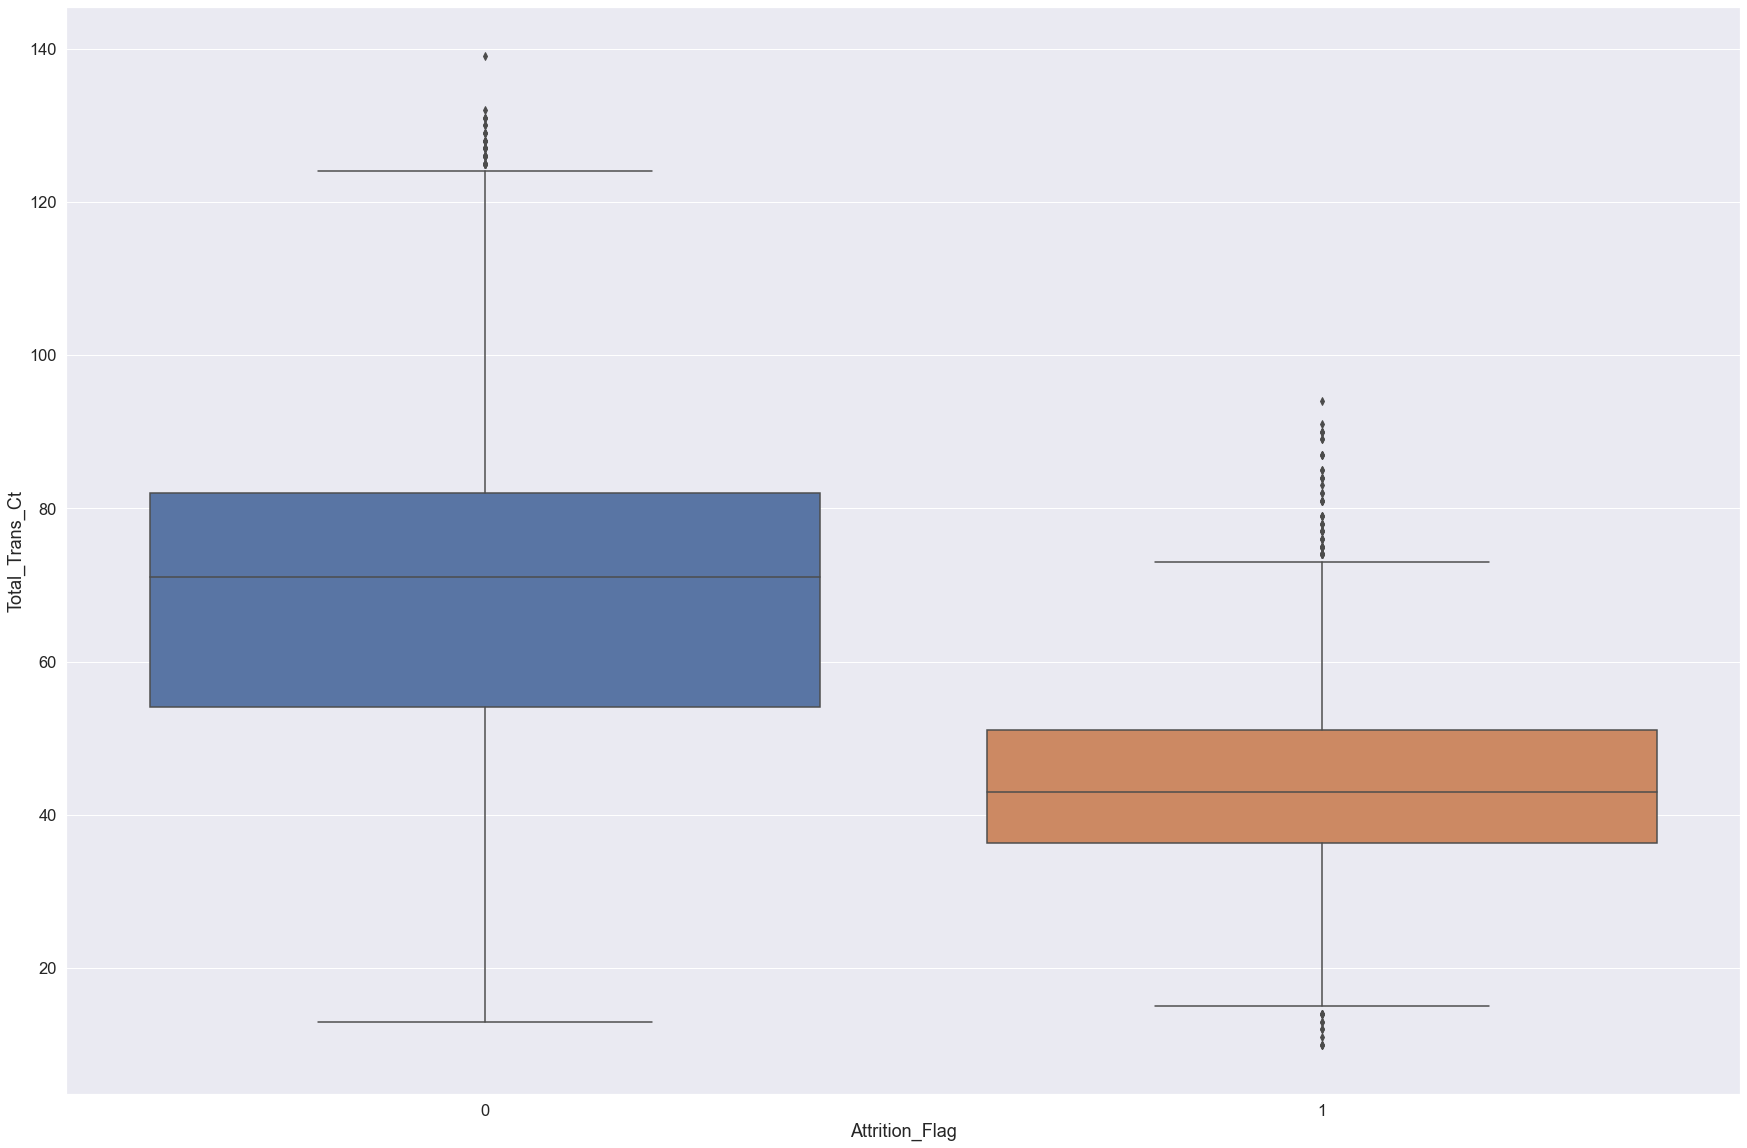

In [32]:
box_plot('Total_Trans_Ct')

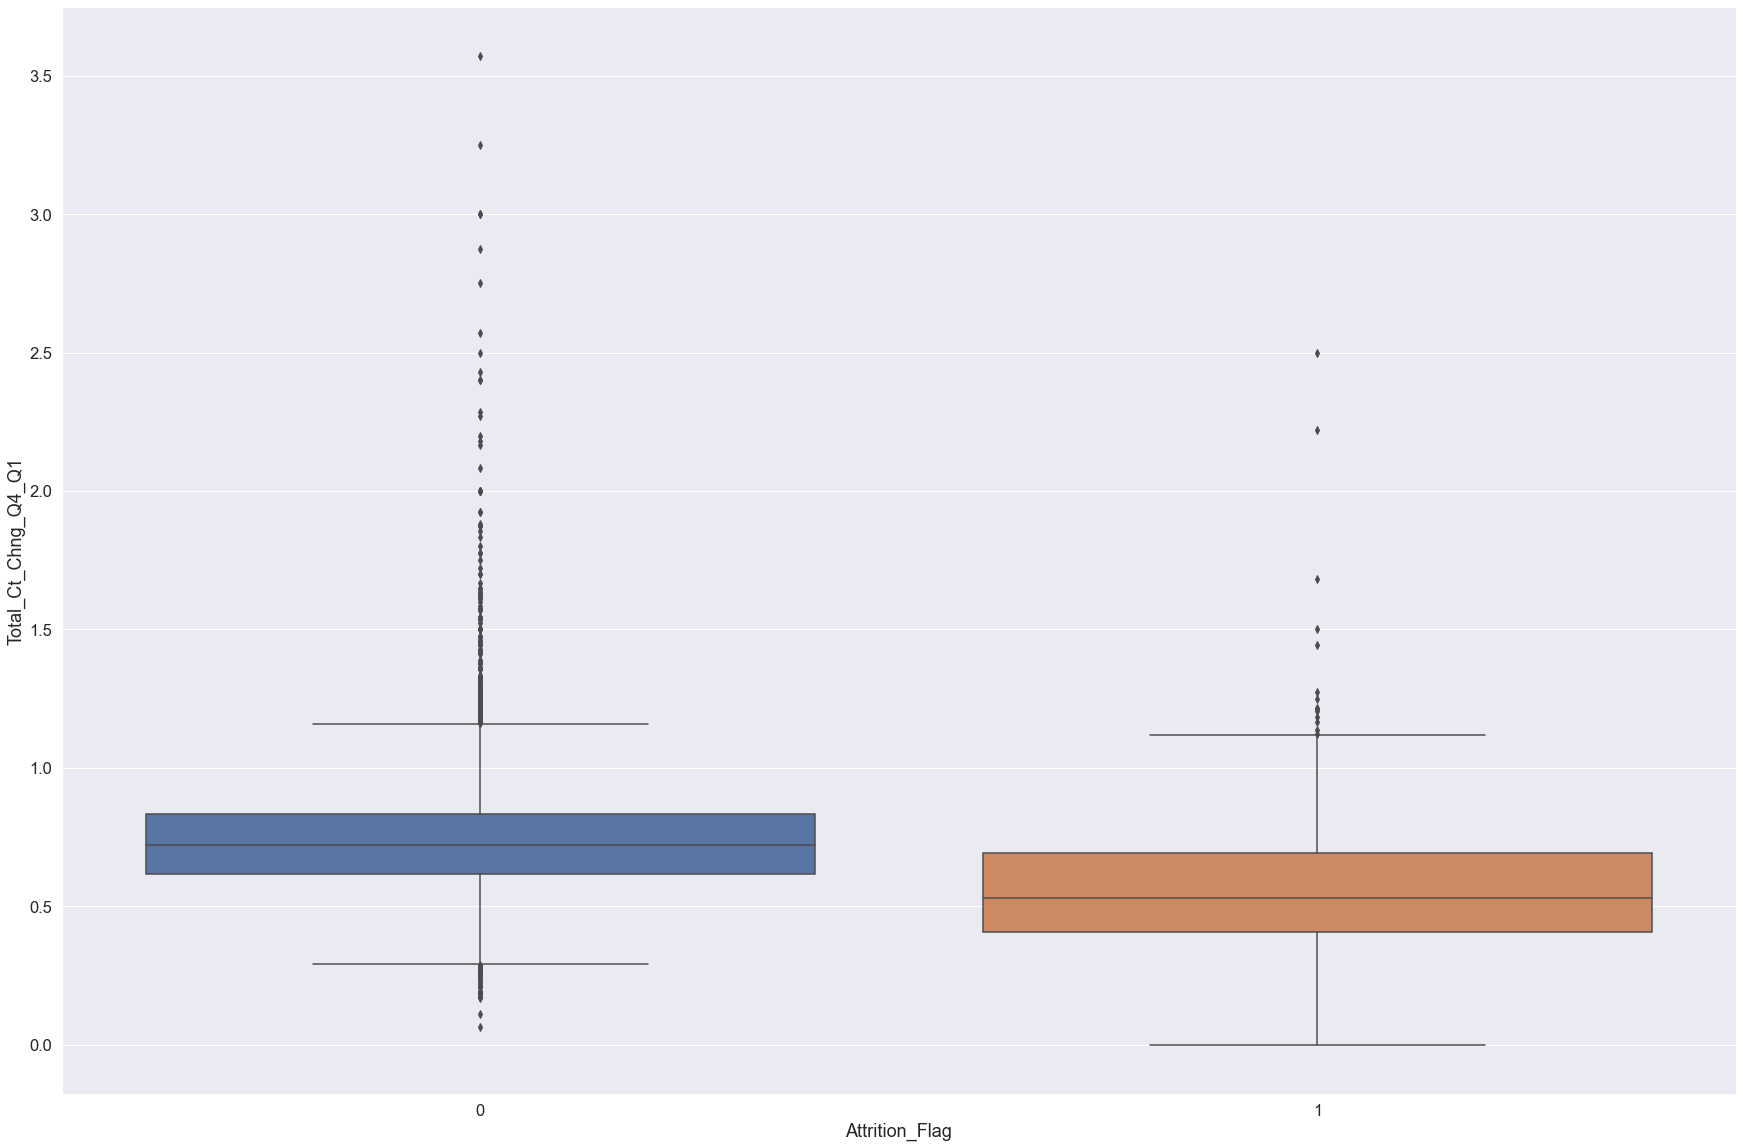

In [33]:
box_plot('Total_Ct_Chng_Q4_Q1')

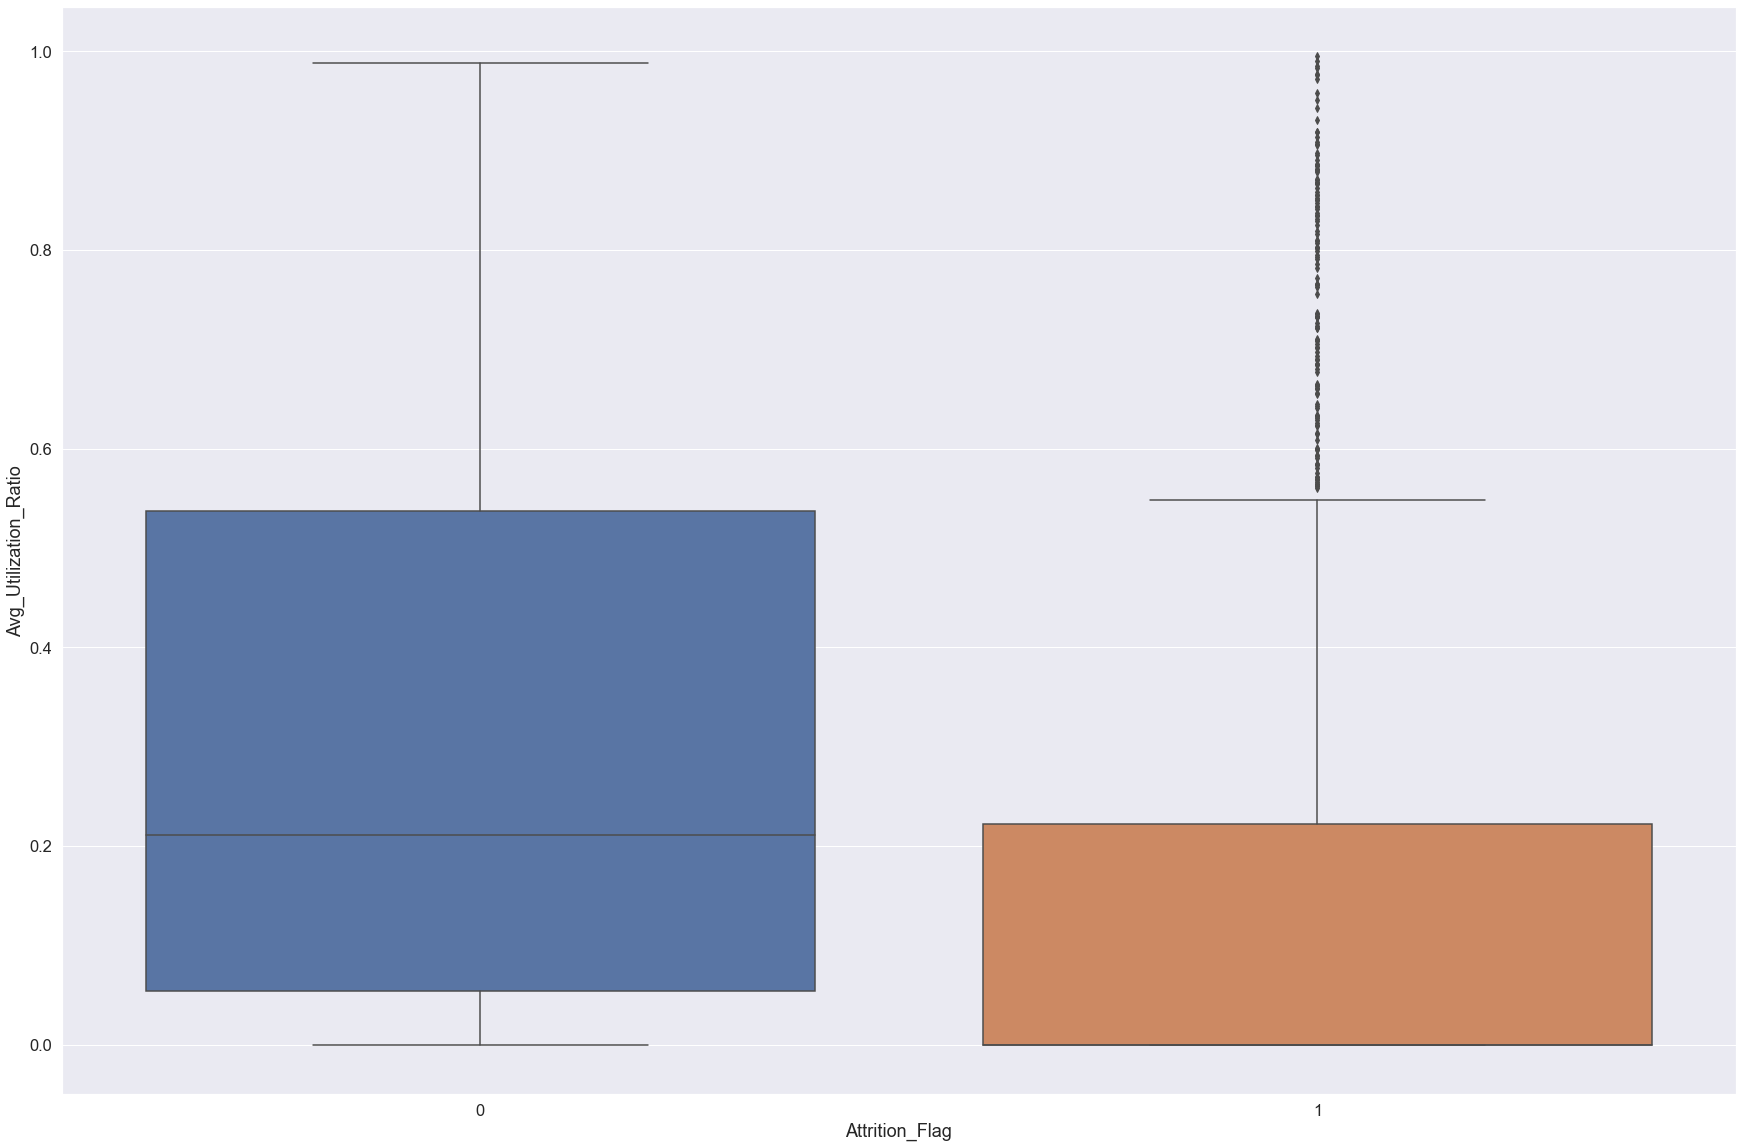

In [34]:
box_plot('Avg_Utilization_Ratio')

## Define a pre-processing pipeline

### Write a custom transform to remove outliers

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin
class RemoveOutliers(BaseEstimator, TransformerMixin):
    
    def __init__(self, feature, min_value, max_value):
        self.feature = feature
        self.min_value = min_value
        self.max_value = max_value
        
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        
        feature_values = X[self.feature]
        feature_values[feature_values < self.min_value ] = self.min_value
        feature_values[feature_values > self.max_value ] = self.max_value
        
        X[self.feature] = feature_values
        
        return X

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold

numerical_pipeline = Pipeline([
    ('age_outliers',RemoveOutliers('Customer_Age',0,70)),
    ('varianceThreshold', VarianceThreshold()),
    ('std_scaler', StandardScaler())])

full_pipeline = ColumnTransformer([("num", numerical_pipeline, numerical_features)])

X_train_values = full_pipeline.fit_transform(X_train)
X_test_values = full_pipeline.transform(X_test)

In [37]:
X_train[numerical_features] = X_train_values
X_test[numerical_features] = X_test_values

In [38]:
train = pd.concat([X_train, y_train],axis=1)
test = pd.concat([X_test, y_test],axis=1)

# Function to remove columns in both train and test set

In [39]:
def remove_columns(df, columns):
    for c in columns:
        if c in df.columns:
            df.drop(c, axis=1, inplace=True)

## Remove highly correlated columns

In [40]:
from scipy.stats import pearsonr
def highly_correleted_columns(df, columns_to_preserve, threshold):
    corr_columns=[]
    for c in df.columns:
        # column to preserve
        if c in corr_columns:
            continue
        # correlation with pval
        for cc in df.columns:
            if cc == c:
                continue
            if cc in columns_to_preserve:
                continue
            if cc in corr_columns:
                continue
            corrtest = pearsonr(df[c], df[cc])
            corr = corrtest[0]
            pval = corrtest[1]
            if abs(corr) > threshold and pval < 0.05:
                corr_columns.append(cc)
    return corr_columns

In [41]:
columns_to_remove = highly_correleted_columns(train,['Attrition_Flag'], 0.70)
columns_to_remove

['Months_on_book',
 'Gender_M',
 'Avg_Open_To_Buy',
 'Total_Trans_Ct',
 'Marital_Status_Single']

In [42]:
remove_columns(train, columns_to_remove)
remove_columns(test, columns_to_remove)

## Remove highly collinear features

In [43]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
def compute_variance_inflation_factor(df, column_to_predict):

    feature_columns = list(df.columns.values)
    # always remove the column to predict
    feature_columns.remove(column_to_predict)
    features = "+".join(feature_columns)

    # get y and X dataframes based on this regression:
    y, X = dmatrices(column_to_predict + '~' + features, data=df, return_type='dataframe')

    # Calculate VIF Factors, for each X, calculate VIF and save in dataframe
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    # Inspect VIF Factors
    print(vif.sort_values('VIF_Factor'))
    return vif

In [44]:
vif = compute_variance_inflation_factor(train, 'Attrition_Flag')

    VIF_Factor                       features
5     1.009329         Months_Inactive_12_mon
6     1.028065          Contacts_Count_12_mon
22    1.031166         Card_Category_Platinum
2     1.032599                Dependent_count
1     1.034012                   Customer_Age
20    1.078386         Marital_Status_Unknown
19    1.091843         Marital_Status_Married
21    1.114080             Card_Category_Gold
4     1.148624       Total_Relationship_Count
9     1.177641           Total_Amt_Chng_Q4_Q1
11    1.196279            Total_Ct_Chng_Q4_Q1
10    1.219928                Total_Trans_Amt
23    1.340913           Card_Category_Silver
3     1.372006                Income_Category
13    1.392088      Education_Level_Doctorate
16    1.458103  Education_Level_Post_Graduate
17    2.141278     Education_Level_Uneducated
18    2.169146        Education_Level_Unknown
8     2.232818            Total_Revolving_Bal
15    2.476174    Education_Level_High_School
7     2.643677                   C

In [45]:
nans_columns = vif[vif.isin([np.nan, np.inf, -np.inf]).any(1)].features.values
remove_columns(train, nans_columns)
remove_columns(test, nans_columns)

In [46]:
highly_collinear = vif.loc[vif.VIF_Factor > 5.0].features.values
remove_columns(train, highly_collinear)
remove_columns(test, highly_collinear)

# 3. Modelling

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score
import optuna

## Plot confusion matrix

In [48]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Compute weights

In [49]:
from sklearn.utils import class_weight
def ComputeWeights(labels):
    sample_weights = class_weight.compute_class_weight('balanced', np.unique(labels), labels)
    weights = []
    for i in range(len(labels)):
        if labels[i] == 0:
            weights.append(sample_weights[0])
        elif labels[i] == 1:
            weights.append(sample_weights[1])

    weights = np.array(weights)
    
    return weights

weights = np.array(ComputeWeights(np.array(y_train)))

## XGBoost classifier

In [50]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV,cross_val_score
def objectiveXGBoost(trial):
    gamma_int = trial.suggest_float('gamma', 0.01, 10,log=True)
    max_depth = trial.suggest_int('max_depth', 1, 5)
    
    fit_params={'sample_weight':weights}
    clf = xgb.XGBClassifier(n_jobs=3,seed=42,gamma=gamma_int,max_depth=max_depth)
    
    return cross_val_score(clf, X_train,y_train, fit_params = fit_params, n_jobs = 3, cv=3, scoring='neg_log_loss').mean()

In [51]:
import optuna
study = optuna.create_study(direction='maximize')
study.optimize(objectiveXGBoost, n_trials=1000)
trial = study.best_trial
print(trial.params)

[I 2021-03-07 21:03:11,450] A new study created in memory with name: no-name-e9978d63-d4c6-4f6c-b48e-0460daab3404
[I 2021-03-07 21:03:13,289] Trial 0 finished with value: -0.10400431606506622 and parameters: {'gamma': 3.336270860381259, 'max_depth': 5}. Best is trial 0 with value: -0.10400431606506622.
[I 2021-03-07 21:03:13,442] Trial 1 finished with value: -0.2111158645202882 and parameters: {'gamma': 0.729859969431966, 'max_depth': 1}. Best is trial 0 with value: -0.10400431606506622.
[I 2021-03-07 21:03:13,591] Trial 2 finished with value: -0.2111158645202882 and parameters: {'gamma': 0.010592558545340277, 'max_depth': 1}. Best is trial 0 with value: -0.10400431606506622.
[I 2021-03-07 21:03:13,942] Trial 3 finished with value: -0.09030598684156042 and parameters: {'gamma': 1.1571249738963898, 'max_depth': 5}. Best is trial 3 with value: -0.09030598684156042.
[I 2021-03-07 21:03:14,085] Trial 4 finished with value: -0.2111158645202882 and parameters: {'gamma': 8.685046482423624, 'm

[I 2021-03-07 21:03:25,428] Trial 42 finished with value: -0.08108565011956016 and parameters: {'gamma': 0.606362239920403, 'max_depth': 4}. Best is trial 32 with value: -0.08077109116455809.
[I 2021-03-07 21:03:25,725] Trial 43 finished with value: -0.08245559317358263 and parameters: {'gamma': 0.5235868192386661, 'max_depth': 4}. Best is trial 32 with value: -0.08077109116455809.
[I 2021-03-07 21:03:25,976] Trial 44 finished with value: -0.08863109592350737 and parameters: {'gamma': 1.2851672709164532, 'max_depth': 3}. Best is trial 32 with value: -0.08077109116455809.
[I 2021-03-07 21:03:26,257] Trial 45 finished with value: -0.10019549199044207 and parameters: {'gamma': 2.7655543804486937, 'max_depth': 4}. Best is trial 32 with value: -0.08077109116455809.
[I 2021-03-07 21:03:26,564] Trial 46 finished with value: -0.08349217049360835 and parameters: {'gamma': 0.7042727527208937, 'max_depth': 4}. Best is trial 32 with value: -0.08077109116455809.
[I 2021-03-07 21:03:26,932] Trial 47

[I 2021-03-07 21:03:38,573] Trial 84 finished with value: -0.08111952398574791 and parameters: {'gamma': 0.46485317029558926, 'max_depth': 4}. Best is trial 32 with value: -0.08077109116455809.
[I 2021-03-07 21:03:38,923] Trial 85 finished with value: -0.08234794255796736 and parameters: {'gamma': 0.4776218153022288, 'max_depth': 4}. Best is trial 32 with value: -0.08077109116455809.
[I 2021-03-07 21:03:39,226] Trial 86 finished with value: -0.0854771155618157 and parameters: {'gamma': 0.3734505049899986, 'max_depth': 4}. Best is trial 32 with value: -0.08077109116455809.
[I 2021-03-07 21:03:39,538] Trial 87 finished with value: -0.08232708561363318 and parameters: {'gamma': 0.6270885450534414, 'max_depth': 4}. Best is trial 32 with value: -0.08077109116455809.
[I 2021-03-07 21:03:39,791] Trial 88 finished with value: -0.08990947674031237 and parameters: {'gamma': 1.1985233026014208, 'max_depth': 3}. Best is trial 32 with value: -0.08077109116455809.
[I 2021-03-07 21:03:40,101] Trial 8

[I 2021-03-07 21:03:52,706] Trial 126 finished with value: -0.08086389433300756 and parameters: {'gamma': 0.4681591716999142, 'max_depth': 4}. Best is trial 32 with value: -0.08077109116455809.
[I 2021-03-07 21:03:53,051] Trial 127 finished with value: -0.08262383316204837 and parameters: {'gamma': 0.5434387150775755, 'max_depth': 4}. Best is trial 32 with value: -0.08077109116455809.
[I 2021-03-07 21:03:53,382] Trial 128 finished with value: -0.08210817784183667 and parameters: {'gamma': 0.48233263574832286, 'max_depth': 4}. Best is trial 32 with value: -0.08077109116455809.
[I 2021-03-07 21:03:53,655] Trial 129 finished with value: -0.085564542580306 and parameters: {'gamma': 0.6328547827489555, 'max_depth': 3}. Best is trial 32 with value: -0.08077109116455809.
[I 2021-03-07 21:03:53,995] Trial 130 finished with value: -0.08469243899158445 and parameters: {'gamma': 0.3603216657813108, 'max_depth': 4}. Best is trial 32 with value: -0.08077109116455809.
[I 2021-03-07 21:03:54,325] Tri

[I 2021-03-07 21:04:07,073] Trial 168 finished with value: -0.08409242469583222 and parameters: {'gamma': 1.0679694976078924, 'max_depth': 4}. Best is trial 154 with value: -0.08073617734724677.
[I 2021-03-07 21:04:07,404] Trial 169 finished with value: -0.08369454317032622 and parameters: {'gamma': 0.6756972537465763, 'max_depth': 4}. Best is trial 154 with value: -0.08073617734724677.
[I 2021-03-07 21:04:07,723] Trial 170 finished with value: -0.08200138941989238 and parameters: {'gamma': 0.4833326998493583, 'max_depth': 4}. Best is trial 154 with value: -0.08073617734724677.
[I 2021-03-07 21:04:08,111] Trial 171 finished with value: -0.0829861515500257 and parameters: {'gamma': 0.42058594739462707, 'max_depth': 4}. Best is trial 154 with value: -0.08073617734724677.
[I 2021-03-07 21:04:08,476] Trial 172 finished with value: -0.08283941753375929 and parameters: {'gamma': 0.5809359965162232, 'max_depth': 4}. Best is trial 154 with value: -0.08073617734724677.
[I 2021-03-07 21:04:08,81

[I 2021-03-07 21:04:22,059] Trial 210 finished with value: -0.08503600400308146 and parameters: {'gamma': 0.7966476723068093, 'max_depth': 4}. Best is trial 154 with value: -0.08073617734724677.
[I 2021-03-07 21:04:22,375] Trial 211 finished with value: -0.08114867717002598 and parameters: {'gamma': 0.6354333973817246, 'max_depth': 4}. Best is trial 154 with value: -0.08073617734724677.
[I 2021-03-07 21:04:22,711] Trial 212 finished with value: -0.08114867717002598 and parameters: {'gamma': 0.6361216741828047, 'max_depth': 4}. Best is trial 154 with value: -0.08073617734724677.
[I 2021-03-07 21:04:23,040] Trial 213 finished with value: -0.08316449425575007 and parameters: {'gamma': 0.6587809826080497, 'max_depth': 4}. Best is trial 154 with value: -0.08073617734724677.
[I 2021-03-07 21:04:23,360] Trial 214 finished with value: -0.08323341662473914 and parameters: {'gamma': 0.7283678636067253, 'max_depth': 4}. Best is trial 154 with value: -0.08073617734724677.
[I 2021-03-07 21:04:23,66

[I 2021-03-07 21:04:36,847] Trial 252 finished with value: -0.08136616386149362 and parameters: {'gamma': 0.5382761169652961, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:04:37,199] Trial 253 finished with value: -0.08355802111106665 and parameters: {'gamma': 0.3986228586886772, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:04:37,573] Trial 254 finished with value: -0.08234794255796736 and parameters: {'gamma': 0.4768943800051394, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:04:37,933] Trial 255 finished with value: -0.08108565011956016 and parameters: {'gamma': 0.6037801179373308, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:04:38,276] Trial 256 finished with value: -0.08205951008718289 and parameters: {'gamma': 0.5536857222771877, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:04:38,62

[I 2021-03-07 21:04:51,761] Trial 294 finished with value: -0.08086389433300756 and parameters: {'gamma': 0.4676132758508638, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:04:52,172] Trial 295 finished with value: -0.08235035249040122 and parameters: {'gamma': 0.44631468839349225, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:04:52,550] Trial 296 finished with value: -0.08334177497491096 and parameters: {'gamma': 0.39473836153264347, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:04:52,893] Trial 297 finished with value: -0.08217038980751647 and parameters: {'gamma': 0.4786602456759939, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:04:53,217] Trial 298 finished with value: -0.08305229157199955 and parameters: {'gamma': 0.332785005720065, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:04:53,5

[I 2021-03-07 21:05:05,840] Trial 335 finished with value: -0.0827959188354463 and parameters: {'gamma': 0.4576997342476495, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:05:06,172] Trial 336 finished with value: -0.0837889783637663 and parameters: {'gamma': 0.6526561747045763, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:05:06,497] Trial 337 finished with value: -0.08138407308100824 and parameters: {'gamma': 0.5362768565835986, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:05:06,849] Trial 338 finished with value: -0.0842063569126466 and parameters: {'gamma': 0.80301450190891, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:05:07,123] Trial 339 finished with value: -0.11517740106271131 and parameters: {'gamma': 4.654372368685034, 'max_depth': 3}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:05:07,468] Tri

[I 2021-03-07 21:05:20,641] Trial 377 finished with value: -0.08188470567603706 and parameters: {'gamma': 0.5094363899498375, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:05:21,008] Trial 378 finished with value: -0.0819160526702432 and parameters: {'gamma': 0.446599375726123, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:05:21,388] Trial 379 finished with value: -0.08615005537497188 and parameters: {'gamma': 0.9824143004962257, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:05:21,730] Trial 380 finished with value: -0.08152923214012404 and parameters: {'gamma': 0.59833192239009, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:05:22,087] Trial 381 finished with value: -0.0841817713487731 and parameters: {'gamma': 0.7487513235982091, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:05:22,458] Tr

[I 2021-03-07 21:05:35,708] Trial 419 finished with value: -0.08111244458864743 and parameters: {'gamma': 0.6483474903938228, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:05:36,080] Trial 420 finished with value: -0.08390392652243704 and parameters: {'gamma': 0.8267270426204063, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:05:36,429] Trial 421 finished with value: -0.0830645026603841 and parameters: {'gamma': 0.6798847584914663, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:05:36,787] Trial 422 finished with value: -0.08393657363415526 and parameters: {'gamma': 0.7404588547552102, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:05:37,156] Trial 423 finished with value: -0.08344548421641244 and parameters: {'gamma': 0.6184352801660674, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:05:37,497

[I 2021-03-07 21:05:50,829] Trial 461 finished with value: -0.08367617011785287 and parameters: {'gamma': 0.6575252973338721, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:05:51,179] Trial 462 finished with value: -0.08212669361651513 and parameters: {'gamma': 0.5590173801447151, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:05:51,541] Trial 463 finished with value: -0.0826215341238618 and parameters: {'gamma': 0.4230726388827384, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:05:51,906] Trial 464 finished with value: -0.08207789004484635 and parameters: {'gamma': 0.4809127260368158, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:05:52,240] Trial 465 finished with value: -0.08500918427143418 and parameters: {'gamma': 0.3363893531959341, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:05:52,566

[I 2021-03-07 21:06:05,514] Trial 503 finished with value: -0.08406052623945855 and parameters: {'gamma': 0.8571369894786823, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:06:05,841] Trial 504 finished with value: -0.08277530082185554 and parameters: {'gamma': 0.5246304667069017, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:06:06,214] Trial 505 finished with value: -0.08375524623378039 and parameters: {'gamma': 0.3926609883434745, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:06:06,596] Trial 506 finished with value: -0.08154900729546 and parameters: {'gamma': 0.28270626365755624, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:06:06,941] Trial 507 finished with value: -0.08152923214012404 and parameters: {'gamma': 0.5999556139190361, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:06:07,281]

[I 2021-03-07 21:06:20,447] Trial 545 finished with value: -0.08162757343018796 and parameters: {'gamma': 0.5709828303991914, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:06:20,798] Trial 546 finished with value: -0.08167138817047594 and parameters: {'gamma': 0.6290756269349391, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:06:21,136] Trial 547 finished with value: -0.08200119395018211 and parameters: {'gamma': 0.5120418464086794, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:06:21,461] Trial 548 finished with value: -0.0820823974270069 and parameters: {'gamma': 0.45886516741506983, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:06:21,787] Trial 549 finished with value: -0.08453411124853051 and parameters: {'gamma': 0.7639480000467117, 'max_depth': 4}. Best is trial 240 with value: -0.08065010374383716.
[I 2021-03-07 21:06:22,13

[I 2021-03-07 21:06:35,144] Trial 587 finished with value: -0.08390392652243704 and parameters: {'gamma': 0.826654526058574, 'max_depth': 4}. Best is trial 556 with value: -0.08057186261636458.
[I 2021-03-07 21:06:35,479] Trial 588 finished with value: -0.08266876878660362 and parameters: {'gamma': 0.5795064512795874, 'max_depth': 4}. Best is trial 556 with value: -0.08057186261636458.
[I 2021-03-07 21:06:35,833] Trial 589 finished with value: -0.08214147272718449 and parameters: {'gamma': 0.5158956592079158, 'max_depth': 4}. Best is trial 556 with value: -0.08057186261636458.
[I 2021-03-07 21:06:36,181] Trial 590 finished with value: -0.08334173533246945 and parameters: {'gamma': 0.6986972343344899, 'max_depth': 4}. Best is trial 556 with value: -0.08057186261636458.
[I 2021-03-07 21:06:36,514] Trial 591 finished with value: -0.08152923214012404 and parameters: {'gamma': 0.5990136648978762, 'max_depth': 4}. Best is trial 556 with value: -0.08057186261636458.
[I 2021-03-07 21:06:36,863

[I 2021-03-07 21:06:49,942] Trial 629 finished with value: -0.08341655664281467 and parameters: {'gamma': 0.30515060179838166, 'max_depth': 4}. Best is trial 556 with value: -0.08057186261636458.
[I 2021-03-07 21:06:50,303] Trial 630 finished with value: -0.08305764851069776 and parameters: {'gamma': 0.40632960544616303, 'max_depth': 4}. Best is trial 556 with value: -0.08057186261636458.
[I 2021-03-07 21:06:50,659] Trial 631 finished with value: -0.08294604992934622 and parameters: {'gamma': 0.38189356609428743, 'max_depth': 4}. Best is trial 556 with value: -0.08057186261636458.
[I 2021-03-07 21:06:51,000] Trial 632 finished with value: -0.08207789004484635 and parameters: {'gamma': 0.4816997859072563, 'max_depth': 4}. Best is trial 556 with value: -0.08057186261636458.
[I 2021-03-07 21:06:51,342] Trial 633 finished with value: -0.08205951008718289 and parameters: {'gamma': 0.5535404540080535, 'max_depth': 4}. Best is trial 556 with value: -0.08057186261636458.
[I 2021-03-07 21:06:51

[I 2021-03-07 21:07:05,033] Trial 671 finished with value: -0.0820823974270069 and parameters: {'gamma': 0.4600418724526264, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:07:05,375] Trial 672 finished with value: -0.08500918427143418 and parameters: {'gamma': 0.3419238543735434, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:07:05,715] Trial 673 finished with value: -0.08215815599494873 and parameters: {'gamma': 0.43649688123101543, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:07:06,078] Trial 674 finished with value: -0.08197167757278821 and parameters: {'gamma': 0.5011063671029731, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:07:06,456] Trial 675 finished with value: -0.08188470567603706 and parameters: {'gamma': 0.5114057323330798, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:07:06,82

[I 2021-03-07 21:07:19,704] Trial 712 finished with value: -0.08256555315725891 and parameters: {'gamma': 0.585045358251147, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:07:20,053] Trial 713 finished with value: -0.08291876333211906 and parameters: {'gamma': 0.5469521928034792, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:07:20,434] Trial 714 finished with value: -0.0829861515500257 and parameters: {'gamma': 0.42039463638980606, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:07:20,819] Trial 715 finished with value: -0.0811347004239724 and parameters: {'gamma': 0.48951181838749075, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:07:21,164] Trial 716 finished with value: -0.0810420566653116 and parameters: {'gamma': 0.6376013790657247, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:07:21,504]

[I 2021-03-07 21:07:34,735] Trial 754 finished with value: -0.08250032437828698 and parameters: {'gamma': 0.43506540174490244, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:07:35,130] Trial 755 finished with value: -0.08298810913591766 and parameters: {'gamma': 0.3259636611517182, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:07:35,502] Trial 756 finished with value: -0.08277530082185554 and parameters: {'gamma': 0.5255322796554085, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:07:35,843] Trial 757 finished with value: -0.08375524623378039 and parameters: {'gamma': 0.39118705864551073, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:07:36,184] Trial 758 finished with value: -0.08218774056022767 and parameters: {'gamma': 0.4846957150656081, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:07:36,

[I 2021-03-07 21:07:49,176] Trial 795 finished with value: -0.0818704578469479 and parameters: {'gamma': 0.5921374660316595, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:07:49,508] Trial 796 finished with value: -0.08234794255796736 and parameters: {'gamma': 0.4780085463410931, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:07:49,845] Trial 797 finished with value: -0.08520490730649934 and parameters: {'gamma': 0.3595410378188684, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:07:50,194] Trial 798 finished with value: -0.08288639556842212 and parameters: {'gamma': 0.6606350273631343, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:07:50,589] Trial 799 finished with value: -0.08262383316204837 and parameters: {'gamma': 0.5435558451601082, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:07:50,973

[I 2021-03-07 21:08:05,436] Trial 837 finished with value: -0.08311049157480611 and parameters: {'gamma': 0.5210876304299834, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:08:05,778] Trial 838 finished with value: -0.08230210929254704 and parameters: {'gamma': 0.41165676914595417, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:08:06,144] Trial 839 finished with value: -0.08440190009470672 and parameters: {'gamma': 0.6536884631963308, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:08:06,519] Trial 840 finished with value: -0.08110286904460112 and parameters: {'gamma': 0.4721862619028194, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:08:06,890] Trial 841 finished with value: -0.08205951008718289 and parameters: {'gamma': 0.5560989359495268, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:08:07,2

[I 2021-03-07 21:08:21,216] Trial 878 finished with value: -0.08379109759974368 and parameters: {'gamma': 0.34777975578455966, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:08:21,585] Trial 879 finished with value: -0.08355802111106665 and parameters: {'gamma': 0.40039661618281236, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:08:21,985] Trial 880 finished with value: -0.0819160526702432 and parameters: {'gamma': 0.44816538471912304, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:08:22,324] Trial 881 finished with value: -0.08111952398574791 and parameters: {'gamma': 0.4627599176183625, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:08:22,693] Trial 882 finished with value: -0.08345282317390872 and parameters: {'gamma': 0.22531851353377977, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:08:23

[I 2021-03-07 21:08:36,987] Trial 920 finished with value: -0.08357496111989256 and parameters: {'gamma': 0.019170983579832615, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:08:37,410] Trial 921 finished with value: -0.08111952398574791 and parameters: {'gamma': 0.46256325438435014, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:08:37,786] Trial 922 finished with value: -0.08111244458864743 and parameters: {'gamma': 0.6468611081661818, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:08:38,207] Trial 923 finished with value: -0.08197167757278821 and parameters: {'gamma': 0.4992327720731917, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:08:38,617] Trial 924 finished with value: -0.08289590621378211 and parameters: {'gamma': 0.8461121420722753, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:08:39

[I 2021-03-07 21:08:52,250] Trial 961 finished with value: -0.08205951008718289 and parameters: {'gamma': 0.5532174959948472, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:08:52,415] Trial 962 finished with value: -0.2111158645202882 and parameters: {'gamma': 0.3081930415388238, 'max_depth': 1}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:08:52,783] Trial 963 finished with value: -0.08316449425575007 and parameters: {'gamma': 0.6597073684945416, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:08:53,160] Trial 964 finished with value: -0.08448252683753715 and parameters: {'gamma': 0.7773341594435044, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:08:53,573] Trial 965 finished with value: -0.08207789004484635 and parameters: {'gamma': 0.4811659673207432, 'max_depth': 4}. Best is trial 653 with value: -0.08048814363786154.
[I 2021-03-07 21:08:53,959

{'gamma': 0.6105549890765548, 'max_depth': 4}


In [55]:
clf = xgb.XGBClassifier()
clf.set_params(**study.best_trial.params)
clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.6105549890765548,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [56]:
yhat = clf.predict(X_test)

Normalized confusion matrix
[[0.98930481 0.01069519]
 [0.13035382 0.86964618]]
Recall is  0.9294754976647845


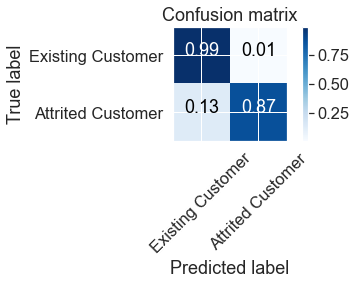

In [57]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[0,1])
plot_confusion_matrix(cnf_matrix, classes=['Existing Customer','Attrited Customer'],normalize=True,  title='Confusion matrix')
print('Recall is ', recall_score(y_test, yhat, average='macro'))